In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.2, rc={'axes.labelsize': 16, 'legend.fontsize': 14, 
                                              'grid.color': '.6', 'grid.linestyle': ':'})
import os
import copy
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, VotingClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier) 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
# !pip install scikit-plot
from scikitplot.metrics import plot_roc, plot_ks_statistic
from lightgbm import LGBMClassifier
# !pip install catboost
from catboost import CatBoostClassifier
# !pip install xgboost
from xgboost.sklearn import XGBClassifier, XGBRegressor
# !pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
# !pip install scikeras
from scikeras.wrappers import KerasClassifier
# !pip install imblearn
from imblearn.over_sampling import SMOTE

# !pip install hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials      # для оптимизации гиперпараметров
from functools import partial 
from scipy.stats import sem, t, norm, ttest_rel, percentileofscore, ks_2samp, kstwo, binom_test, bayes_mvs
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# !pip install git+https://github.com/WillKoehrsen/feature-selector.git
from feature_selector import FeatureSelector


import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)
tf.random.set_seed(0)

# Содержание
0. Загрузка данных и создание лучших моделей
1. Проверка воспроизводимости результов моделей (сравнение с результами второго ноутбука)
2. Анализ качества данных
    1. Анализ данных после заполнения пропусков
    2. Матрица корреляций
    3. Анализ мультиколлинеарности
    4. Рекомендации: группы проверок качества данных, необходимых для подтверждения возможности использования данного набора данных
    5. Слабые зоны для переменных, участвующих в разработке модели
3. Количественная валидация  
    1. Вспомогательные функции для проведения тестов и визуализаций в разрезе модели и факторов
    2. Тестирование факторов
    3. Тестирование моделей
    4. Отчеты интерпретации Shap
4. Вывод    

# 0. Загрузка данных

In [2]:
# тренировочные и тестовые данные
X_train = pd.read_csv("srm23-spring-bank-scoring-case/X_train.csv")
X_test = pd.read_csv("srm23-spring-bank-scoring-case/X_test.csv")
y_train = pd.read_csv("srm23-spring-bank-scoring-case/y_train.csv")
# удаляем из трейна людей, чей возраст меньше 18 лет (это делалось в том ноутбуке)
X_train = X_train[X_train.age>18]
y_train = y_train[y_train.index.isin(X_train.index)]

# Те же данные, но с заполненными пропусками (..._final - с помощью KNN Imputer, 20 соседей; ..._median - медианой)
X_train_final = pd.read_csv('srm23-spring-bank-scoring-case/X_train_final.csv', index_col=0)
X_test_final = pd.read_csv('srm23-spring-bank-scoring-case/X_test_final.csv', index_col=0)
X_train_median = pd.read_csv('srm23-spring-bank-scoring-case/X_train_median.csv', index_col=0)
X_test_median = pd.read_csv('srm23-spring-bank-scoring-case/X_test_median.csv', index_col=0)

# результаты подбора гиперпараметров
history_LGBM = pd.read_csv('srm23-spring-bank-scoring-case/history_LGBM.csv')
history_catboost = pd.read_csv('srm23-spring-bank-scoring-case/history_catboost.csv')
history_xg = pd.read_csv('srm23-spring-bank-scoring-case/history_xg.csv')
history_gbc = pd.read_csv('srm23-spring-bank-scoring-case/history_gbc.csv')
history_blend_cb_lgbm = pd.read_csv('srm23-spring-bank-scoring-case/history_blend_cb_lgbm.csv')
history_blend_cb_lgbm_nn = pd.read_csv('srm23-spring-bank-scoring-case/history_blend_cb_lgbm_nn.csv')

In [3]:
# Вытаскиваем оптимальные гиперпараметры
def get_opt_params(history):
    '''
    Получая датафрейм истории подбора гиперпараметров, функция возвращает оптимальные значения гиперпараметров
    '''
    best_params = eval(history.iloc[0]['params'])
    best_params = {key.replace('model__', ''): value for key, value in best_params.items()}
    return best_params

# и сразу же вызываем
best_LGBM_params = get_opt_params(history_LGBM)
best_catboost_params = get_opt_params(history_catboost)
best_xg_params = get_opt_params(history_xg)
best_gbc_params = get_opt_params(history_gbc)

In [4]:
# масштабирование данных
num_pipe = Pipeline([('scaler', StandardScaler())])
transformer = ColumnTransformer(
                    transformers=[('num', num_pipe, X_train.columns)],
                                   remainder='passthrough')

# 1. Проверим, что результаты воспроизводимы

In [5]:
def get_score_statistic(pipeline, num_splits=5, X=X_train_final, show_stats='True'):
    '''
    Получение результатов обучения пайплайна: 10 раз рассчитывается roc_auc на кросс-валидации
    return: 10*num_splits значений метрики
    '''
    scores = np.array([])
    for i in range(10):
        fold = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = i)
        scores_on_this_split = cross_val_score(estimator=pipeline, X=X, y=y_train, scoring='roc_auc', 
                                               cv=fold, n_jobs=-1)
        scores = np.append(scores, scores_on_this_split)
    
    if show_stats =='False':
        return scores
    
    print('Среднее:', np.mean(scores))
    print('СКО:', np.std(scores))
    
    return scores


# создание модели нейросети
def create_model():
    model = keras.Sequential([
          layers.Dense(64, input_dim=10, activation='relu'), # 'LeakyReLU'
          layers.Dense(16, activation='relu'),
          layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0003), metrics=[keras.metrics.AUC()])
    return model

Создание пайплайнов

In [6]:
LGBM_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",    LGBMClassifier(n_estimators=60, random_state=0, n_jobs=-1, class_weight='balanced', **best_LGBM_params))
])

catboost_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   CatBoostClassifier(n_estimators=165, random_state=0, silent=True, **best_catboost_params))
])

xg_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",   XGBClassifier(n_estimators=28, random_state=0, **best_xg_params))
])

gbc_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model",  GradientBoostingClassifier(n_estimators=150, random_state=0, verbose=3, **best_gbc_params))
]) 

nn_pipeline = Pipeline([
    ("transformer", transformer),  
    ("model", KerasClassifier(model=create_model, epochs=150, batch_size=1000,  validation_split=0.2, 
                              shuffle=True, verbose=0, random_state=0)) # callbacks=[early_callback, lr_callback],
]) 


# # результаты (проверка воспроизводимости)
# print('LGBM:')
# LGBM_res = get_score_statistic(LGBM_pipeline)
# print('CatBoost:')
# catboost_res = get_score_statistic(catboost_pipeline)
# print('XGBoost:')
# xg_res = get_score_statistic(xg_pipeline)
# print('GBC:')
# gbc_res = get_score_statistic(gbc_pipeline)
# print('Neural Network:')
# nn_res = get_score_statistic(nn_pipeline)

In [7]:
# блендинги 
vc_cb_lgbm = VotingClassifier([('catboost', catboost_pipeline), 
                               ('LGBM', LGBM_pipeline)], 
                                voting='soft', weights=[0.9, 0.1])

vc_cb_lgbm_nn = VotingClassifier([('catboost', catboost_pipeline), 
                                  ('LGBM', LGBM_pipeline),
                                  ('neural_network', nn_pipeline)], 
                                  voting='soft', weights=[0.8, 0.05, 0.15])

# # результаты (проверка воспроизводимости)
# print('CatBoost + LGBM:')
# vc_cb_lgbm_res = get_score_statistic(vc_cb_lgbm)
# print('CatBoost + LGBM + NN:')
# vc_cb_lgbm_nn_res = get_score_statistic(vc_cb_lgbm_nn)

### Вывод:
Удалось получить воспроизводимые результаты.

# 2. Анализ качества данных

Во втором ноутбуке исследовались достаточно подробно тренировочные и тестовые данные. Было обнаружено, что в столбцах `monthly_income` и `family_members` имеются пропуски в количестве 20% и 2.5% соответственно. Поэтому данные этих столбцов нужно было аккуратно заполнять, решено было остановиться на KNN Imputer с 20 соседями. Несмотря на то, что распределения этих двух признаков практически не изменились после импутации (ниже графики), все-таки это является слабым местом модели.

### 2.1 Анализ данных после заполнения пропусков

In [8]:
def dist_box(col, dtype='float', bins = 100, dataframe=X_train_final, data='train'):
    '''
    построение гистограммы распределения признака (с выделением цветом таргета) и boxplot над ним
    col - исследуемый признак
    dtype - тип данных признака (float/int)
    data - train или test датафрейм
    bins - количество столбцов в гистограмме
    dataframe - X_train_final/X_train/X_test/X_test_final
    '''
    if data == 'train':
        X = dataframe.merge(y_train, left_index=True, right_index=True)
    else:
        X = dataframe.copy(deep=True)
    
    fig, (ax_box, ax_dis) = plt.subplots(nrows=2,sharex=True, gridspec_kw = {"height_ratios": (0.25, 0.75)}, figsize=(7, 4))
    mean, median = X[col].mean(), X[col].median() 
    formatted_mean, formatted_median = "{:.2f}".format(mean), "{:.2f}".format(median)
    fig.suptitle(f"Распределение '{col}' в X_{data}", fontsize=16, fontweight='bold')
    
    # boxplot
    sns.boxplot(x=X[col], showmeans=True, orient='h',color="tan", ax=ax_box)
    ax_box.set(xlabel='')

    # histplot
    params_test = {'data': X, 'x': col, 'bins': bins, 'ax': ax_dis}
    params_float = {'data': X, 'x': col, 'hue': 'target', 'multiple': 'stack', 'bins': bins, 'ax': ax_dis} 
    
    if data == 'train':
        if dtype == 'float':
            sns.histplot(kde=True, **params_float)
        else:
            sns.histplot(discrete=True, **params_float)

        hist_legend = ax_dis.legend(labels=["1", "0"], loc='center right', title='target')
        ax_dis.add_artist(hist_legend)

    elif data == 'test':
        if dtype == 'float':
            sns.histplot(kde=True, **params_test)
        else:
            sns.histplot(discrete=True, **params_test)

    # матожидание и медиана
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2, label=f'Mean = {formatted_mean}')
    ax_dis.axvline(median, color='g', linestyle='-', linewidth=2, label=f'Median = {formatted_median}')
    ax_dis.legend()
    
    
def plot_class_ratio(ax, col, bins=100, rotation=0):
    '''
    Построение графика зависимости отношения количества объектов, принадлежащих к разным классам от значения признака
    ax - объект рисунка
    col - признак
    bins - количество столбцов гистограммы
    rotation - угол поворота подписи оси абсцисс
    '''
    # извлечение информации о столбцах гистограммы
    heights = [p.get_height() for p in ax.patches]
    heights_class_1 = heights[:len(heights)//2] # высота столбца с target = 1
    heights_class_0 = heights[len(heights)//2:] # высота столбца с target = 0
    class_ratio = [a/b if b!=0 else 0 for a,b in zip(heights_class_1,heights_class_0) ] # отношение высот столбцов
    coords = [p.get_x() + p.get_width() / 2. for p in ax.patches]
    coords = coords[:len(coords)//2]  # координаты столбцов
    fig, ax_class = plt.subplots(figsize=(8, 4))
    ax_class = sns.barplot(x=coords, y=class_ratio, color='orange', width=0.99)
    ax_class.set(xlabel=col, ylabel='class1/class0_ratio', title='Зависимость отношения классов от значения признака')
    ax_class.set_xticks(range(len(coords))[::(bins//10)], [round(x,2) for x in coords[::(bins//10)]], rotation=rotation)       

#### Сравнение распределений признаков после импутации

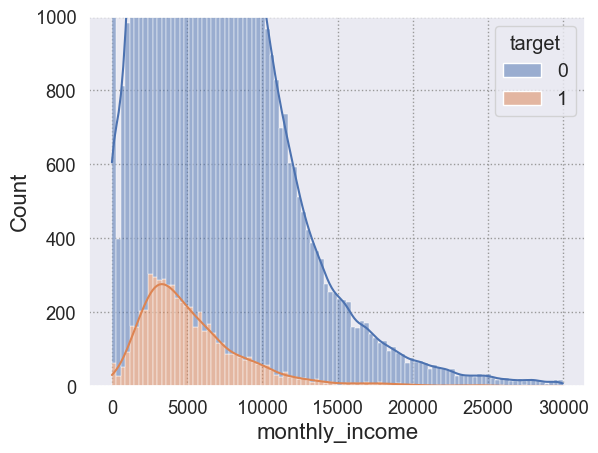

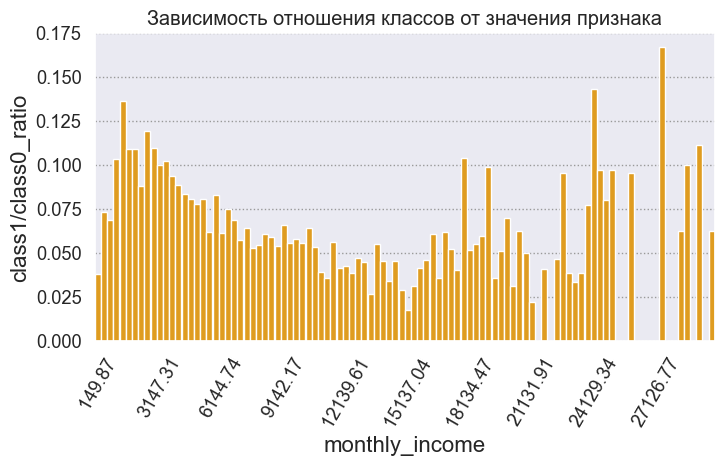

In [9]:
# monthly_income до импутации
ax=sns.histplot(data=X_train[X_train.monthly_income<30_000].merge(y_train, left_index=True, right_index=True), 
              x='monthly_income', kde=True, hue='target', multiple='stack', bins=100)
ax.set_ylim([0,1000])
plot_class_ratio(ax, 'monthly_income', rotation=60)
plt.show()

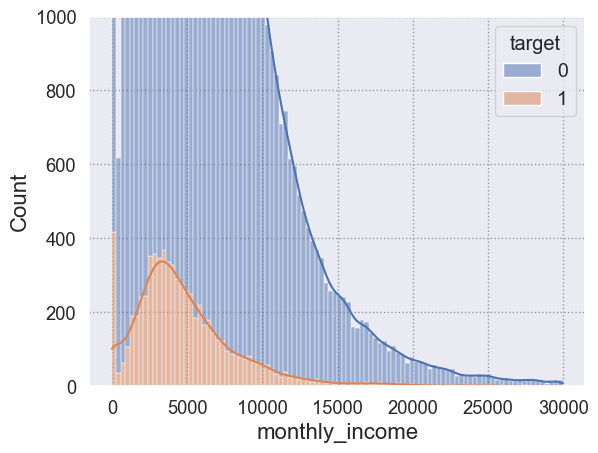

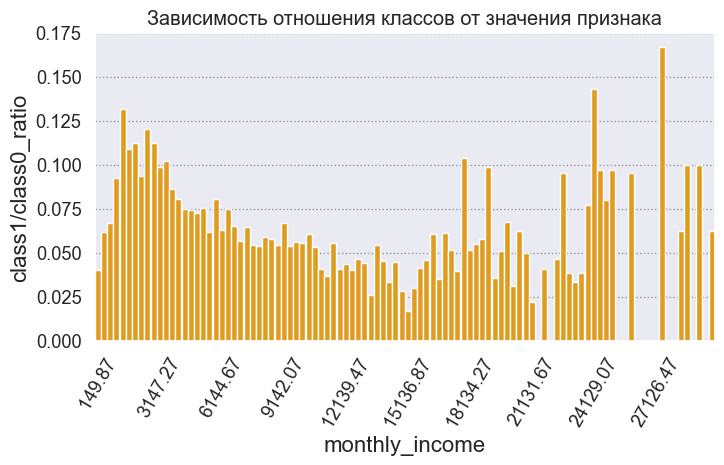

In [10]:
# monthly_income после импутации
ax=sns.histplot(data=X_train_final[X_train_final.monthly_income<30_000].merge(y_train, left_index=True, right_index=True), 
              x='monthly_income', kde=True, hue='target', multiple='stack', bins=100)
ax.set_ylim([0,1000])
plot_class_ratio(ax, 'monthly_income', rotation=60)
plt.show()

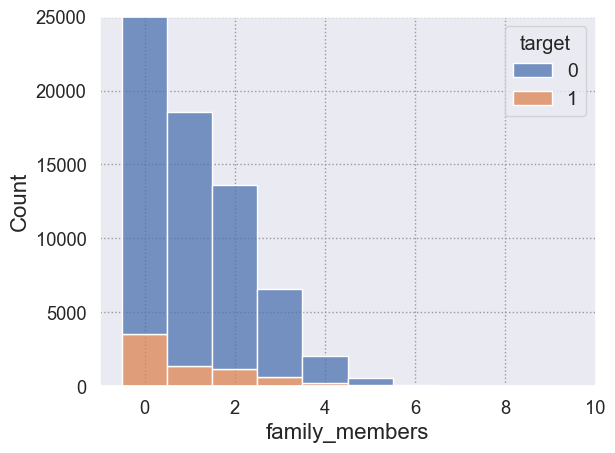

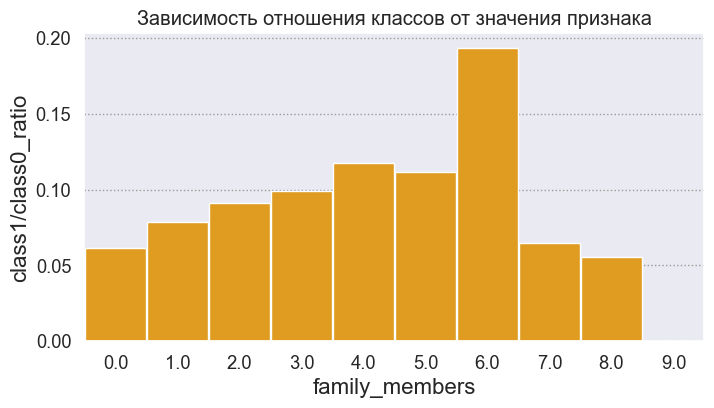

In [11]:
# family_members до импутации
ax=sns.histplot(data=X_train[X_train.family_members<10].merge(y_train, left_index=True, right_index=True), 
              x='family_members', discrete=True, hue='target', multiple='stack', bins=10)
ax.set_ylim([0, 25000])
plot_class_ratio(ax, 'family_members', bins=10)
plt.show()

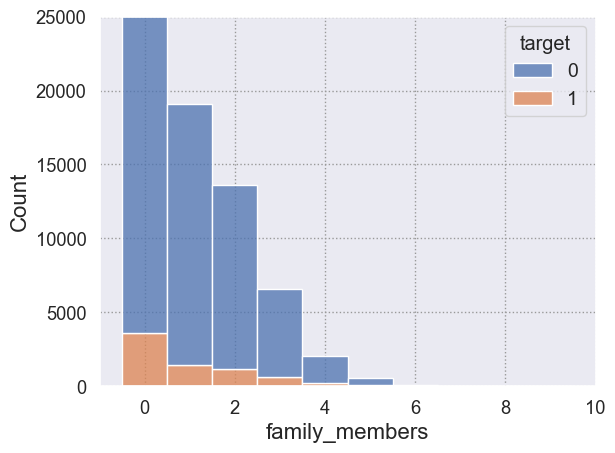

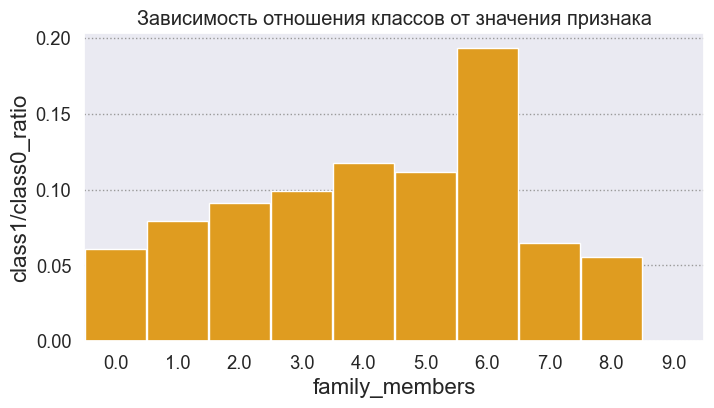

In [12]:
# family_members после импутации
ax=sns.histplot(data=X_train_final[X_train_final.family_members<10].merge(y_train, left_index=True, right_index=True), 
              x='family_members', discrete=True, hue='target', multiple='stack', bins=10)
ax.set_ylim([0, 25000])
plot_class_ratio(ax, 'family_members', bins=10)
plt.show()

Как видим после импутации распределения этих признаков практически никак не изменились, даже зависимость отношения элементов различных классов от значения соответствующего признака. Однако возможно это довольно "грубо" заполнять число членов семьи на основе схожих данных других заемщиков.

Что касается других данных, то как в трейне, так и в тесте имелись выбросы, поэтому я их не удалял (кроме возрастного признака: там были люди(1 человек точнее), возраст которых 0). С точки зрения логики все данные были достоверные (например нет такого, что число займов отрицательное и т.п.)

Также была построена матрица парных корреляций (продублирую ниже), которая подтвердила очевидную сильную зависимость друг с другом между `overdue_30_59_days`, `overdue_60_89_days`, `overdue__more_than_90_days`, однако после удаления двух из этих трех признаков качество модели значительно ухудшается, поэтому были оставлены все 3 признака.

### 2.2 Матрица корреляций

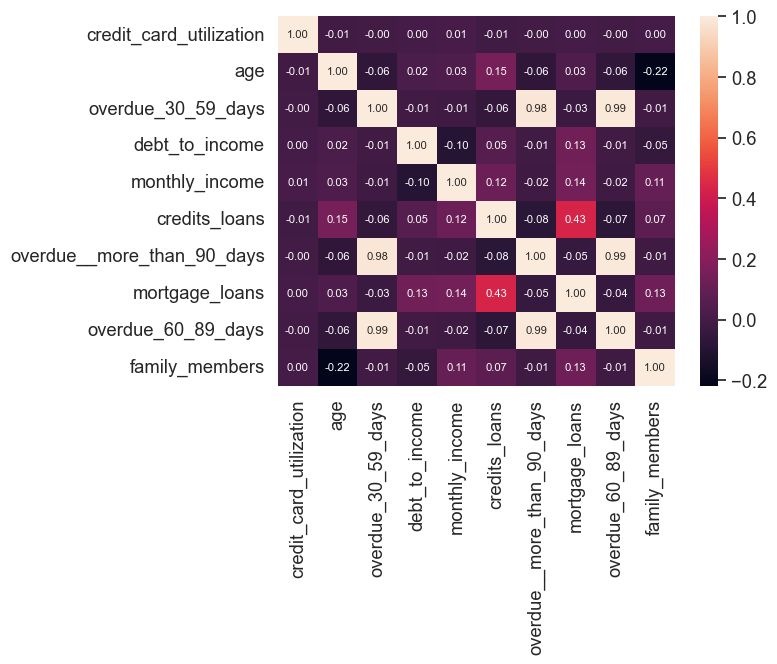

In [13]:
# матрица корреляций
sns.heatmap(X_train_final.corr(), fmt=".2f", annot=True, annot_kws={'fontsize':8})
plt.show()

### 2.3 Анализ мультиколлинеарности

In [14]:
# добавление константы для модели sm.OLS
X_train_with_const = sm.add_constant(X_train_final)

# расчет VIF для каждого признака
vif = pd.Series([variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])], 
                index=X_train_with_const.columns)

# вывод результатов
print(vif)

'''
VIF - это мера того, насколько много информации об общей дисперсии модели множественной регрессии содержится в каждом 
признаке. Если значение VIF для признака равно 1, это означает, что этот признак независим от других признаков. Если 
значение VIF для признака больше 1, это означает, что этот признак коррелирует с другими признаками. Чем выше значение VIF, 
тем сильнее мультиколлинеарность между признаками (после 5 считается, что очень сильная мультиколлинеарность).
'''
print()

const                         17.617391
credit_card_utilization        1.000425
age                            1.088376
overdue_30_59_days            42.044808
debt_to_income                 1.034443
monthly_income                 1.047491
credits_loans                  1.281130
overdue__more_than_90_days    78.390799
mortgage_loans                 1.274981
overdue_60_89_days            96.747849
family_members                 1.088111
dtype: float64



В принципе еще раз убедился, что `overdue_30_59_days`, `overdue_60_89_days` и `overdue__more_than_90_days` сильно коррелируют друг с другом, однако, как я уже писал ранее, после удаления двух из этих трех признаков качество модели значительно ухудшается, хотя дисперсия, естественно, при этом тоже уменьшается, но не достаточно сильно. Поэтому были оставлены все эти признаки и далее работал я уже не с линейными моделями.

### 2.4 Рекомендации: группы проверок качества данных, необходимых для подтверждения возможности использования данного набора данных

1. Проверка наличия пропущенных значений и их заполнение (была проведена KNN импутация). Была гипотеза о том, что monthly_income=NaN в том случае, когда человек безработный и доходов нет у него, потому что из 20000 пропусков в 19000 пропуски наблюдаются в строках, где большое значение debt/income (деление на 0 грубо говоря). Однако KNN Imputer это "заметил" и во многих таких пропусках вставил 0.
2. Проверка на наличие дубликатов (При анализе данных было найдено всего 137 дубликатов из более 100к данных и поэтому было решено не удалять дубликаты. Однако если придется использовать другие данные, то следует проверять и по возможности удалять дубликаты)
3. Проверка на соответствие типов данных (В этом плане все данные были нужных типов, за исключением family_members: вместо int - float, однако после запятой стояли только нули и т.к. потом все равно происходило масштабирование данных, то это не так важно)
4. Проверка на наличие выбросов и аномальных значений (Как уже было отмечено ранее, имеются выбросы как в train, так и в test, например число членов семьи = 20? Возраст=111? В принципе, такие данные возможны и я их не очищал, однако возможно стоило бы внести определенные ограничения)
5. Проверка на наличие ошибок в данных/несогласованности данных (например, будет странно, если credits_loans будет меньше, чем mortgage_loans, т.е. если общее число займов будет меньше, чем число ипотечных займов, а также если число членов семьи отрицательное)

In [15]:
# monthly_income = NaN, когда debt_to_income очень большое? (в 18000 из 20000 случаях ответ да)
display(X_train[(X_train['debt_to_income']>20) & (X_train['debt_to_income']!=0) & (pd.isna(X_train['monthly_income']))])

# Проверка на наличие ошибок credits_loans vs mortgage_loans
print(sum(X_train.credits_loans<X_train.mortgage_loans))

credit_card_utilization  age  overdue_30_59_days  debt_to_income  \
20                     1.156862   69                   0       34.666092   
23                     0.176205   93                   0      297.962783   
36                     0.280279   49                   0     2226.820771   
39                     0.148479   47                   0     5322.022996   
40                     0.027631   55                   0     7393.317898   
...                         ...  ...                 ...             ...   
105066                 0.000000   45                   0     2173.670773   
105068                 1.103362   48                   2     2637.329638   
105073                 0.017397   74                   0      419.385987   
105077                 0.039235   60                   0     3670.266118   
105091                 0.293973   38                   0     3082.137895   

        monthly_income  credits_loans  overdue__more_than_90_days  \
20                 NaN              0                           0   
23                 NaN              3                           0   
36                 NaN              6                           0   
39                 NaN             15                           0   
40                 NaN             12                           0   
...                ...            ...                         ...   
105066             NaN              7                           0   
105068             NaN              7                           0   
105073             NaN             12                           0   
105077             NaN             13                           0   
105091             NaN              8                           0   

        mortgage_loans  overdue_60_89_days  family_members  
20                   0                   0             0.0  
23                   0                   0             NaN  
36                   2                   0             2.0  
39                   3                   0             2.0  
40                   2                   0             0.0  
...                ...                 ...             ...  
105066               1                   0             0.0  
105068               1                   0             0.0  
105073               0                   0             0.0  
105077               3                   0             0.0  
105091               1                   0             0.0  

[18287 rows x 10 columns]

0


## 2.5 Слабые зоны для переменных, участвующих в разработке модели

Определение слабых зон для переменных - это процесс анализа данных, направленный на выявление переменных, которые слабо влияют на целевую переменную. Такие переменные несут мало информации и могут быть исключены из модели, чтобы улучшить ее качество и уменьшить ее сложность. Для определения слабых зон для переменных можно использовать различные методы, такие как корреляционный анализ, анализ дисперсии, анализ главных компонент и др. 

В работе строились графики зависимости отношения объектов в двух классах в зависимости от признака и в итоге соотношение объемов классов не было постоянным => хорошие признаки (ну разве что family_members: там не сильные изменения, но все же они есть). 

Также с помощью feature_selector было произведено предобучение модели, благодаря которому было выяснено, что порядок признаков по важности от самого важного до наименее важного следующий:
- monthly_income
- debt_to_income
- credit_card_utilization
- age
- credit_loans
- overdue_30_59_days
- mortgage_loans
- overdue_60_89_days
- overdue__more_than_90_days
- family_members

Однако график cumulative_feature_importance показал, что на признак family_members приходится 3% важности, поэтому он был оставлен.

Можно построить корреляционную матрицу и из нее найти информацию о корреляции между каждым признаком и таргетом (в следующей ячейке код). В результате обнаруживанием, что максимальные значения коэффициентов корреляции у overdue_30_59_days, overdue_60_89_days, verdue__more_than_90_days и age, однако они сами по себе небольшие: до 0.15.

#####  Корреляции признаков с таргетом

In [16]:
all_data=X_train_final.copy(deep=True)
all_data['target'] = y_train.target
# корреляционная матрица
corr_matrix = all_data.corr()
# вывод корреляций с целевой переменной
print(corr_matrix['target'])

credit_card_utilization      -0.000641
age                          -0.116230
overdue_30_59_days            0.130301
debt_to_income               -0.008378
monthly_income               -0.018394
credits_loans                -0.028205
overdue__more_than_90_days    0.121366
mortgage_loans               -0.006807
overdue_60_89_days            0.106931
family_members                0.051350
target                        1.000000
Name: target, dtype: float64


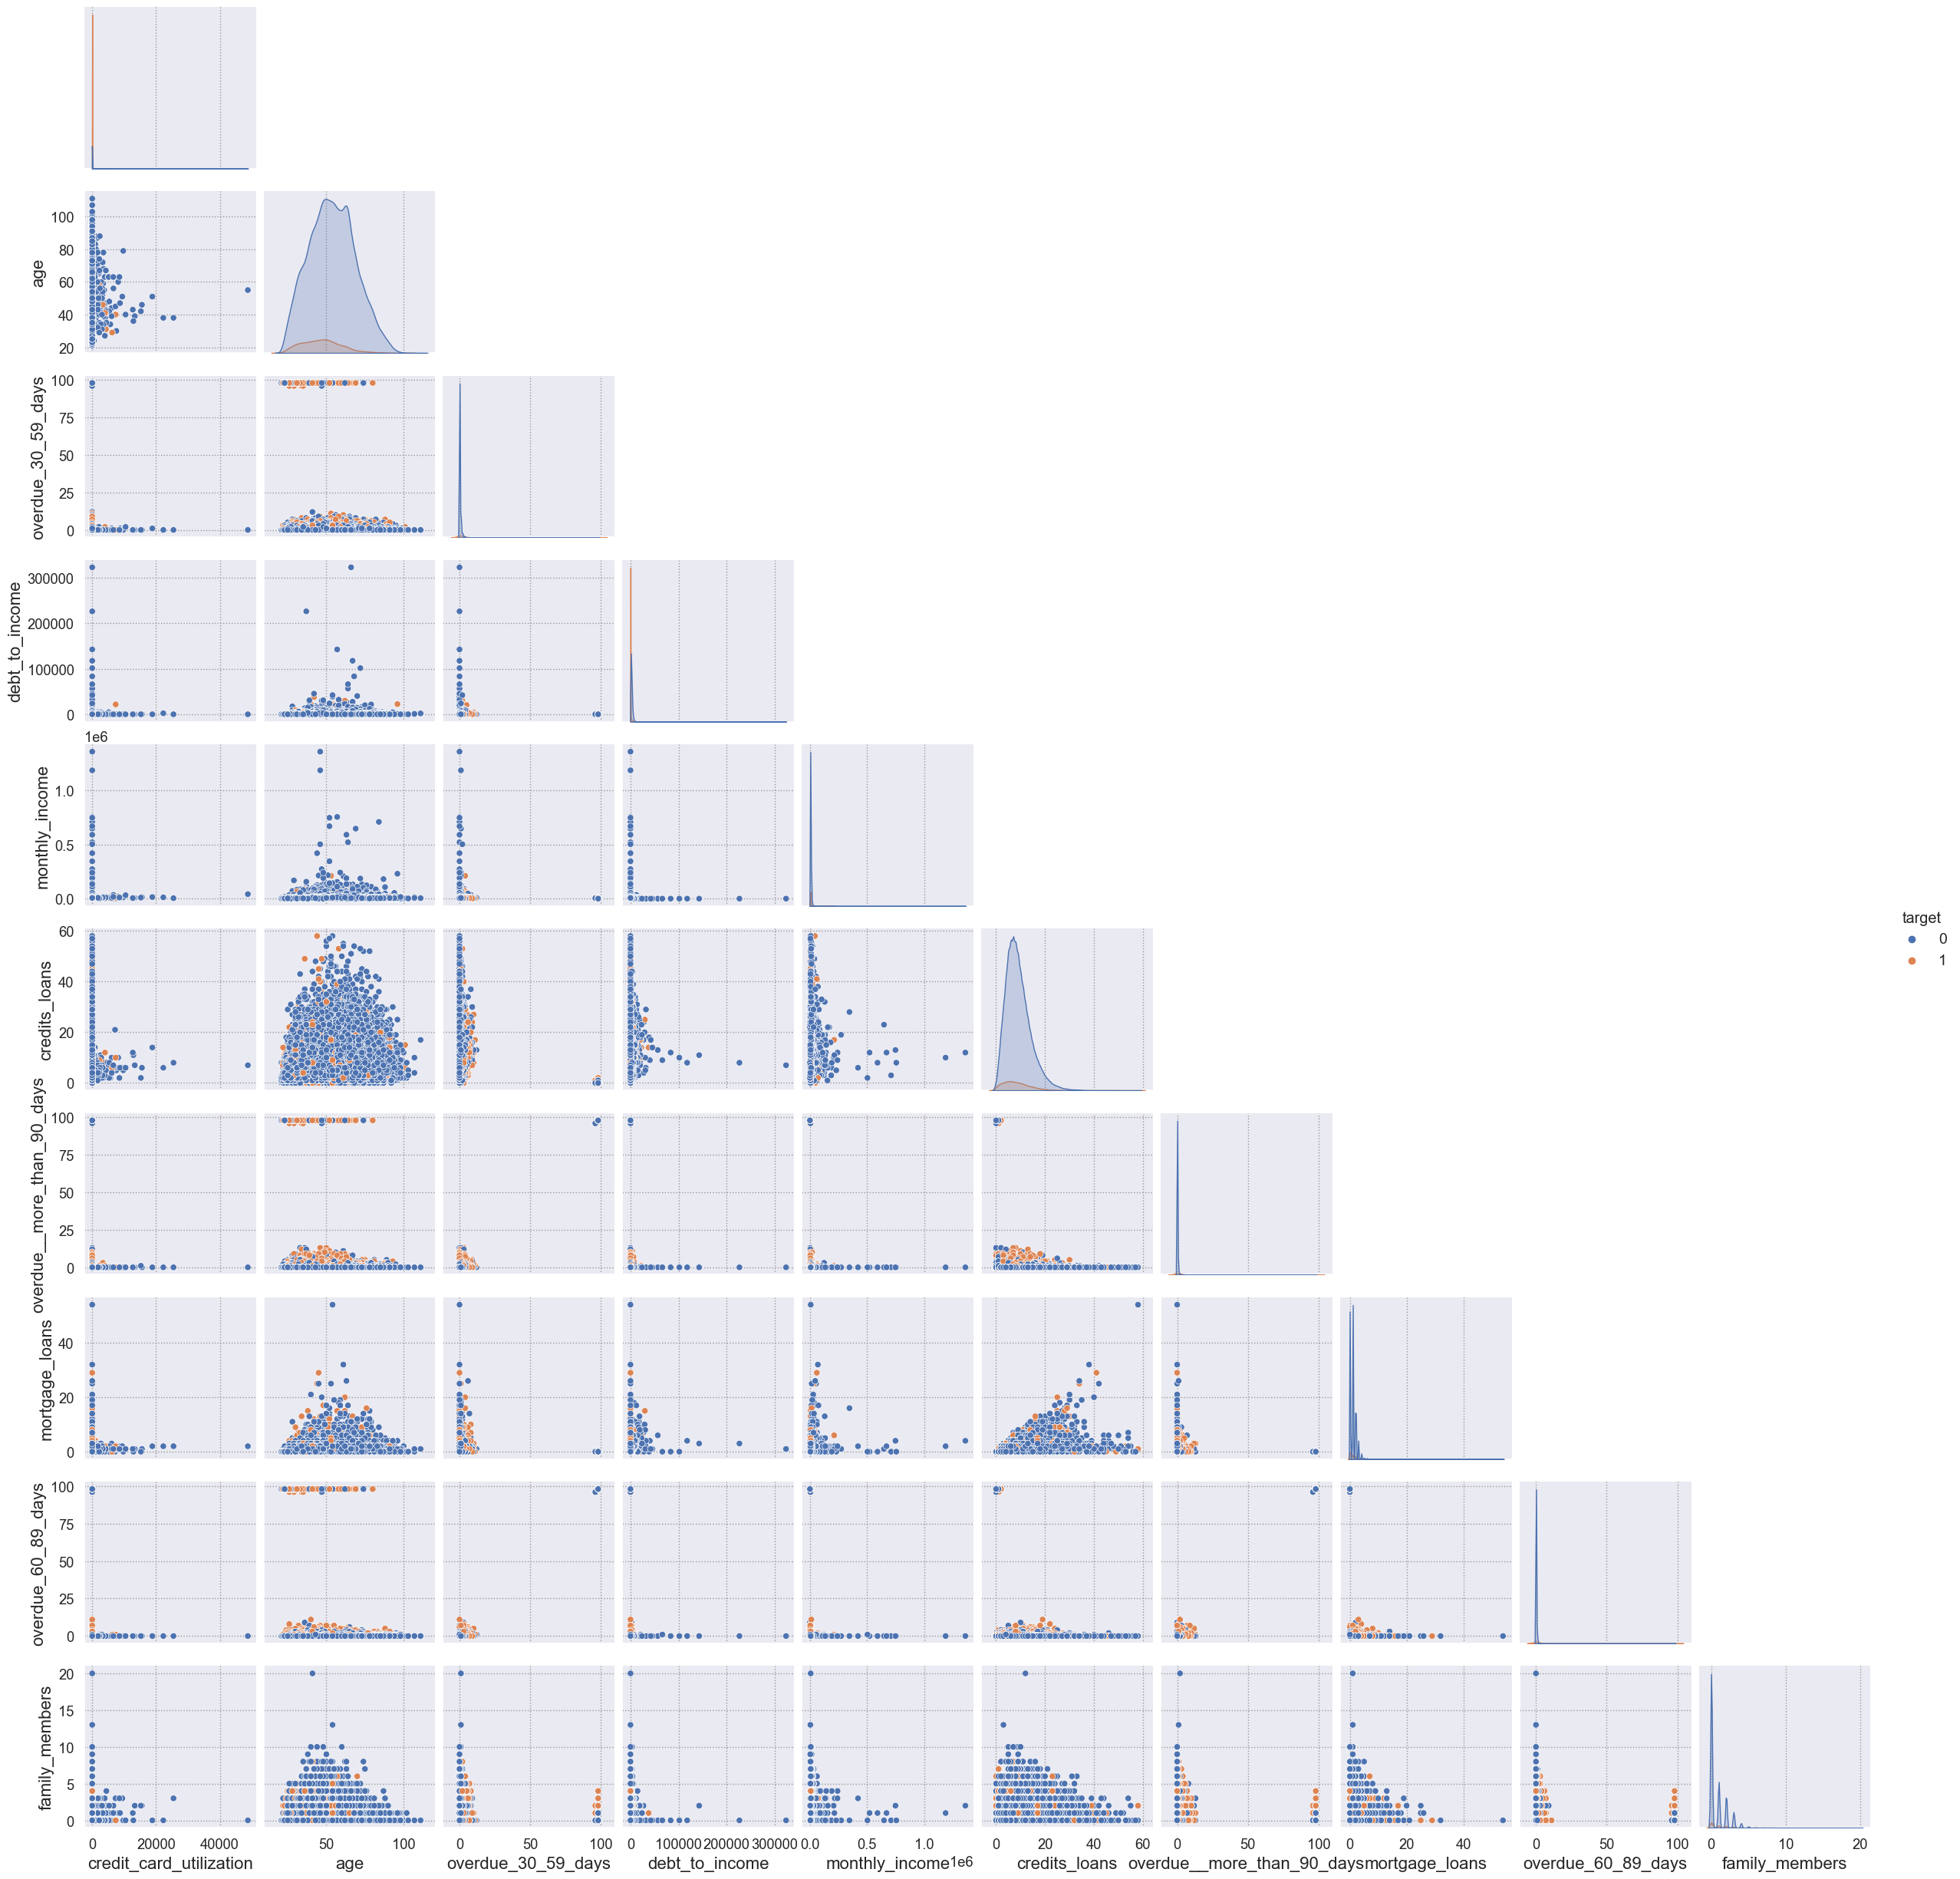

In [17]:
# pairplots
sns.pairplot(all_data, hue="target", corner=True)
plt.show()

##### Наблюдения:
1. С увеличением возраста клиента при небольших значениях отношения баланса на счету к лимиту по кредиту меньше случаев дефолта
2. С увеличением overdue_... расчет число дефолтов практически при любых значениях других признаков
3. Сильная корреляция между тремя признаками overdue...
4. Из-за выбросов сложно сделать много качественных выводов...

# 3. Количественная валидация

Разделим `X_train_final` на 2 части в пропорции 80% на 20% с сохранением соотношения классов.

In [18]:
# Разделим данные на обучающую и тестовую выборки
X_tr, X_te, y_tr, y_te = train_test_split(X_train_final, y_train, test_size=0.2, random_state=42, stratify=y_train)
print(sum(y_tr.target)/len(y_tr))
print(sum(y_te.target)/len(y_te))
y_tr, y_te = y_tr.target, y_te.target

0.06689579716005042
0.0668823137665303


In [19]:
# Обучение моделей
catboost_pipeline.fit(X_tr, y_tr)
LGBM_pipeline.fit(X_tr, y_tr)
xg_pipeline.fit(X_tr, y_tr)
gbc_pipeline.fit(X_tr, y_tr)
nn_pipeline.fit(X_tr, y_tr)

# блендинги 
vc_cb_lgbm.fit(X_tr, y_tr)           
vc_cb_lgbm_nn.fit(X_tr, y_tr)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.4921           0.0055           44.84s
         2           0.4894           0.0052           44.13s
         3           0.4814           0.0050           40.44s
         4           0.4778           0.0049           39.15s
         5           0.4728           0.0047           37.42s
         6           0.4679           0.0045           37.07s
         7           0.4629           0.0045           36.07s
         8           0.4608           0.0040           35.22s
         9           0.4555           0.0038           35.10s
        10           0.4535           0.0037           34.71s
        11           0.4461           0.0036           34.36s
        12           0.4473           0.0034           34.08s
        13           0.4438           0.0032           34.26s
        14           0.4382           0.0032           34.04s
        15           0.4314           0.0030           33.70s
       

       133           0.3608          -0.0000            4.11s
       134           0.3655          -0.0000            3.86s
       135           0.3623           0.0000            3.62s
       136           0.3604          -0.0000            3.38s
       137           0.3655           0.0000            3.14s
       138           0.3632          -0.0000            2.89s
       139           0.3594          -0.0000            2.65s
       140           0.3605          -0.0000            2.41s
       141           0.3607          -0.0000            2.17s
       142           0.3598          -0.0000            1.92s
       143           0.3588           0.0000            1.68s
       144           0.3632          -0.0000            1.44s
       145           0.3631          -0.0000            1.20s
       146           0.3618           0.0000            0.96s
       147           0.3613           0.0000            0.72s
       148           0.3575          -0.0000            0.48s
       1

VotingClassifier(estimators=[('catboost',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['credit_card_utilization', 'age', 'overdue_30_59_days',
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_8...
                                                                                Index(['credit_card_utilization', 'age', 'overdue_30_59_days',
       'debt_to_income', 'monthly_income', 'credits_loans',
       'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days',
       'family_members'],
      dtype='object'))])),
                                              ('model',
                                               KerasClassifier(batch_size=1000, epochs=150, model=<function create_model at 0x0000020F1A67A0E0>, random_state=0, validation_split=0.2, verbose=0))]))],
                 voting='soft', weights=[0.8, 0.05, 0.15])

## 3.1 Вспомогательные функции для тестирования модели и факторов

В ячейке ниже приведены вспомогательные функции для проведения нескольких тестов и визуализаций:

1. В разрезе факторов:
    1. Тест Gini: эффективность ранжирования факторов (red_signal<0.05, yellow_signal<0.15)
    2. 2.5 перцентиль бутстрэп-распределения Джини по факторам (red_zone=0.03, yellow_zone=0.05)
    3. Information Value test
    4. Индексы PSI
2. В разрезе модели:
    1. Тест Gini: эффективность ранжирования модели (red_signal<0.4, yellow_signal<0.6)
    2. 2.5 перцентиль бутстрэп-распределения Джини по модели (red_zone=0.3, yellow_zone=0.45)
    3. Оценка важности признаков на тестовых данных путем перемешивания значений признака для объектов
    4. Построение графика важности признаков при обучении модели 
    5. Построение распределений вероятностей дефолта
    6. Тест Колмогорова-Смирнова
    7. Анализ калибровки

##### Оценка Джини в разрезе факторов

In [20]:
# Функция для проведения оценки Джини в разрезе факторов
def get_ginis_of_features(X_tr=X_tr, y_tr=y_tr, X_te=X_te, y_te=y_te, red_zone=0.05, yellow_zone=0.15):
    '''
    Оценка Джини в разрезе факторов с визуализацией
    X_te, y_tr, X_te, y_te - тренировочные и тестовые данные
    red_zone, yellow_zone - пороговые значения для риск-зоны 
    print: red/yellow/green signal вместе со значением Gini "худшего" признака
    '''
    # расчет коэффициента Джини для каждого фактора
    gini_scores = {}
    for feature in X_tr.columns:
        # обучение модели на обучающей выборке с использованием только одного фактора
        model = LogisticRegression(random_state=0)
        model.fit(X_tr[[feature]], y_tr)

        # предсказание на тестовой выборке
        y_pred = model.predict_proba(X_te[[feature]])[:, 1]

        # расчет коэффициента Джини
        gini_score = 2 * roc_auc_score(y_te, y_pred) - 1
        gini_scores[feature] = abs(gini_score) # вывожу модуль, т.к. сильно отрицательное значение это тоже нормально
    
    results = pd.Series(gini_scores).sort_values(ascending=False)
    
    # Визуализация
    fig, ax = plt.subplots()
    ax.bar(results.index, results)
    ax.set(title='Gini scores for each feature', xlabel='Features', ylabel='Gini coefficient')
    plt.xticks(rotation=90)
    plt.show()
    
    # Худший признак
    min_gini, worst_feature = results[-1], results.index[-1]
    print(f'Эффективность ранжирования факторов:')
    if min_gini < red_zone:
        return f'Red signal: {worst_feature} has Gini = {"{:.4f}".format(min_gini)}'
    if min_gini < yellow_zone:
        return f'Yellow signal: {worst_feature} has Gini = {"{:.4f}".format(min_gini)}'
    
    return f'Green signal: {worst_feature} has Gini = {"{:.4f}".format(min_gini)}'
 


# функция для проверки 2.5 перцентиля бутстрэп-распределения Джини по факторам
def get_ginis_of_features_bootstrap(X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te, sample_fraction=0.5, 
                                    n_samples=1000, alpha=0.025, red_zone=0.03, yellow_zone=0.05):
    '''
    X_train, y_train, X_test, y_test - тренировочные и тестовые данные
    sample_fraction - размер одного сэмпла (доля от размера тестовой выборки)
    n_samples - число сэмплов
    alpha - перцентиль бутстрэп-распределения
    red_zone, yellow_zone - пороговые значения для риск-зоны
    print: red/yellow/green signal с пояснениями
    '''
    gini_scores = []
    n = len(y_test)
    samples = []
    for i in range(n_samples):
        # частоты 
        freqs = np.random.poisson(1, n)
        # с учетом частот "расширяем" список индексов дубликатами
        indices = np.repeat(np.arange(n), freqs)
        # перемешиваем
        indices = np.random.permutation(indices)
        # возвращаем только sample_fraction от всей выборки
        indices = indices[:round(sample_fraction*n)]
        # бутстрэп-сэмплирование
        y_test_sampled = y_test.to_numpy()[indices]
        X_test_sampled = X_test.iloc[indices]

        # получение gini score признаков
        for feature in X_test_sampled.columns:
            X_feature = X_test_sampled[feature]
            gini_score = 2*roc_auc_score(y_test_sampled, X_feature) - 1
            gini_scores.append((feature, abs(gini_score)))

    # датафрейм резульатов        
    results = pd.DataFrame(gini_scores).rename(columns={0:'feature', 1:'gini'})     
    # для каждого признака получаем alpha перцентиль
    results = results.groupby('feature')['gini'].quantile(alpha).sort_values()
    
    # признаки в красной и желтой зоне
    red_features = results[results<=red_zone]
    yellow_features = results[(results>red_zone) & (results<=yellow_zone)]
    
    # вывод результатов теста
    print(f'{alpha} перцентиль бутстрэп-распределения Джини по факторам:')
    if len(red_features) !=0:
        print('Red signal:')
        for index, value in red_features.iteritems():
            print(f'{index} имеет {alpha} перцентиль gini = {"{:.4f}".format(value)}') 
        return    
    
    if len(yellow_features) !=0:
        print('Yellow signal: ')
        for index, value in yellow_features.iteritems():
            print(f'{index} имеет {alpha} перцентиль gini = {"{:.4f}".format(value)}')
        return  
    
    print('Green signal:', f' худший признак {results.index[0]} имеет {alpha} перцентиль gini = {"{:.4f}".format(results[0])}')


##### Вычисление Information value

In [21]:
# функция для расчета IV
def calc_iv(df, var_name, target_name, epsilon=0.0001):
    '''
    df - тренировочнй датасет
    var_name - переменная, для которой рассчитывается IV
    target_name - название таргета
    epsilon - добавка для устранения проблемы деления на 0
    return: IV признака
    '''
    # создаем сводную таблицу
    pivot = pd.pivot_table(df, values=target_name, index=var_name, aggfunc=[np.sum, len])
    pivot.columns = ['bad', 'total']
    pivot['good'] = pivot['total'] - pivot['bad']
    pivot['bad_pct'] = (pivot['bad'] + epsilon) / (pivot['bad'].sum() + epsilon)
    pivot['good_pct'] = (pivot['good'] + epsilon) / (pivot['good'].sum() + epsilon)
    pivot['weight_of_evidence'] = np.log(pivot['good_pct'] / pivot['bad_pct'])
    pivot['iv'] = (pivot['good_pct'] - pivot['bad_pct']) * pivot['weight_of_evidence']
    iv = pivot['iv'].sum()
    return iv

def get_inform_values(X_train=X_tr, y_train=y_tr, no_value=0.02, small_value=0.1, middle_value=0.3):
    X = X_train.join(y_train)
    # некоторые признаки принимают дробные значения, поэтому имеет смысл их разложить в бины
    for col in ['credit_card_utilization', 'monthly_income', 'debt_to_income']:
        X[col] = pd.qcut(X[col], q=200, duplicates='drop')
    
    print('Оценка information value:')
    # расчет IV для переменных
    results = []
    for feature in X_train.columns:
        iv = calc_iv(X, feature, 'target')
        print(f'IV for {feature}: {iv}')
        results.append((feature, iv))
    
    results = pd.DataFrame(results).rename(columns={0:'feature', 1: 'IV'}).sort_values('IV', ascending=False)
    
    # Визуализация на графике
    fig, ax = plt.subplots()
    ax.bar(results.feature, results.IV)
    ax.set(title='Information value for each feature', xlabel='Features', ylabel='Information value')
    # Добавляем горизонтальные линии
    ax.axhline(y=no_value, color='r', linestyle='--')
    ax.axhline(y=small_value, color='y', linestyle='--')
    ax.axhline(y=middle_value, color='g', linestyle='--')
    plt.xticks(rotation=90)
    # Добавляем легенду
    ax.legend(['Не значимый признак', 'Низкая значимость', 'Средняя значимость', 'IV'])
    plt.show()

#### Расчет индекса PSI

In [22]:
# вспомогательная функция для изменения границ категорий бинов
def update_category(cat, min_value = -1, max_value=1e8):
    '''
    cat - объект типа Category
    min_value - в первой категории левая граница заменится на это число
    max_value - в последней категории правая граница заменится на это число
    return: измененный объект Category
    '''
    # заменяем первый элемент на [0, right]
    left, right = cat.categories[0].left, cat.categories[0].right
    new_category = pd.Interval(left=min_value, right=right)
    categories = [new_category] + list(cat.categories[1:])

    # заменяем последний элемент на (left, max_value]
    left, right = cat.categories[-1].left, max_value
    new_category = pd.Interval(left=left, right=right)
    categories = list(categories[:-1]) + [new_category]

    # создаем новый объект категории и возвращаем его
    return pd.Categorical.from_codes(cat.codes, categories=categories, ordered=cat.ordered)


# Основная функция для расчета PSI
def get_PSI(df_train = X_tr, df_test=X_te, col='age', num_bins=10, min_value=-1, max_value=1e10, epsilon=0.0000001):
    '''
    Вычисление индекса PSI по факторам
    df_train, df_test - тренировочный и тестовый датафреймы
    col - признак для которого рассчитывается PSI
    num_bins - число бинов для расчета PSI
    min_value, max_value - на какие значения изменить границы крайних категорий
    epsilon - поправка для борьбы с делением на 0 или логарифмированием
    return: pd.DataFrame с результатами расчетов + индекс PSI
    '''
    # получение границ бинов
    bins = pd.qcut(df_train[col], q=num_bins, duplicates='drop')
    
    # подсчет наблюдений в каждом бине
    counts_train = bins.value_counts()
    
    # далее изменим границы первого и последнего бина (выставим что первый от -min_value до ..., а последний 
    # от ... до max_value), потому что в тестовой выборке могут быть данные за пределами тренировочных
    new_bins = update_category(counts_train.index)
    
    # разделяем на те же бины и считаем количество наблюдений в каждом бине в тестовом наборе данных
    counts_test = pd.cut(df_test[col], bins=new_bins.categories).value_counts()
    
    # далее сортировка по индексам
    counts_train, counts_test = counts_train.sort_index(), counts_test.sort_index()
    counts_train.index = counts_test.index
    counts_train.name, counts_test.name  = counts_train.name+'_train_amount', counts_test.name+'_test_amount'
    
    # результаты заносим в новый датафрейм
    results=pd.concat([counts_train,counts_test], axis=1)
    
    # расчет долей
    results['train_ratio'] = results[f'{col}_train_amount'] / len(df_train)
    results['test_ratio'] = results[f'{col}_test_amount'] / len(df_test)
    
    # небольшие изменения, если нулевые значения (чтобы потом не было проблем при делении на 0 и логарифмировании)
    results['train_ratio'] = results['train_ratio'].replace(0., epsilon)
    results['test_ratio'] = results['test_ratio'].replace(0., epsilon)
    
    # расчет изменения долей
    results['delta_ratio'] = results['test_ratio'] - results['train_ratio']
    
    # расчет отношения долей
    results['divide'] = results['test_ratio'] / results['train_ratio']
    
    # расчет логарифма от отношения долей
    results['ln'] = np.log(results['divide'])
    
    # расчет индекса
    results['Index'] = results['delta_ratio'] * results['ln']
    
    PSI = results['Index'].sum()
    
    return results, PSI


# вспомогательная функция для интерпретации индекса PSI
def fill_PSI_test(x):
    if x <= 0.1:
        return 'Green signal: нет значимых изменений'
    if x <= 0.25:
        return 'Yellow signal: незначительные изменения'
    else:
        return 'Red signal: значительное смещение => нужно перестроить модель'


#  функция для вывода результатов PSI теста по факторам
def get_PSI_results(X_train=X_tr, X_test=X_te):
    '''
    X_train, X_test - тренировочный и тестовый датафрейм
    return: индексы PSI для каждого фактора + интерпретация (red/yellow/green)
    '''
    print('Анализ PSI по факторам:')
    psis = []
    for feature in X_train.columns:
        calculations, psi = get_PSI(X_train, X_test, feature)
        psis.append(psi)
    
    # датафрейм с индексами PSI    
    results = pd.DataFrame({'feature': X_train.columns, 'PSI': psis}).sort_values('PSI', ascending=False)    
    results['conclusion'] = results['PSI'].apply(fill_PSI_test)

    display(results)

##### Оценка Джини в разрезе модели

In [23]:
# функция для расчета gini_score
def gini(y_true, y_pred):
    '''
    y_true: истинные метки классов тестовой выборки
    y_pred: предсказанные моделью "вероятности" на тестовой выборке
    '''
    return 2 * roc_auc_score(y_true, y_pred) - 1

# создаем метрику на основе функции gini_score
gini_scorer = make_scorer(gini, greater_is_better=True)

# функция для сэмплирования
def generate_bootstrap_samples(y_true, y_pred, sample_fraction = 0.5, n_samples=1000):
    '''
    y_true: истинные метки классов тестовой выборки
    y_pred: предсказанные моделью "вероятности" на тестовой выборке
    sample_fraction - размер одного сэмпла (доля от размера тестовой выборки)
    n_samples - число сэмплов
    return: [(y_sample_true, y_sample_pred), ...] y_sample_true - метки классов сэмпла, y_sample_pred - "вероятности" сэмпла
    '''
    n = len(y_true)
    samples = []
    for i in range(n_samples):
        # частоты 
        freqs = np.random.poisson(1, n)
        # с учетом частот "расширяем" список индексов дубликатами
        indices = np.repeat(np.arange(n), freqs)
        # перемешиваем
        indices = np.random.permutation(indices)
        # возвращаем только sample_fraction от всей выборки
        indices = indices[:round(sample_fraction*n)]
        #непосредственно сэмплирование
        y_true_sampled = y_true.to_numpy()[indices]
        y_pred_sampled = y_pred[indices]
        samples.append((y_true_sampled, y_pred_sampled))
    return samples


# функция для вычисления значений коэффициентов gini сэмплов + для построения графиков gini_scores и roc_auc_scores
def compute_ginis(samples, confidence=95):
    '''
    samples - [(y_sample_true, y_sample_pred), ...] y_sample_true - метки классов сэмпла, y_sample_pred - "вероятности" сэмпла
    confidence - доверительный интервал (в %)
    return: ginis (np.array значений gini)
    '''
    # значения gini_score для сэмплов
    ginis = np.array([gini(y_true_sampled, y_pred_sampled) for y_true_sampled, y_pred_sampled in samples])
    
    # доверительный интервал для gini
    lower_gini = max(0.0, np.percentile(ginis, (100 - confidence)/2))
    upper_gini = min(1.0, np.percentile(ginis, (100 + confidence)/2))
    
    # то же самое для roc_auc
    roc_aucs = [0.5 * (gini + 1) for gini in ginis]
    lower_auc, upper_auc = 0.5 * (lower_gini + 1), 0.5 * (upper_gini + 1)
    
    # визуализация распределений
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(ginis, ax=ax1)
    sns.histplot(roc_aucs, ax=ax2)
    ax1.set(title='Распределение коэффициентов gini')
    ax2.set(title='Распределение roc_auc')
    plt.show()
    
    print(f'{confidence}%-ный доверительный интервал для gini: {"[{:.4f}, {:.4f}]".format(lower_gini, upper_gini)}')
    print(f'{confidence}%-ный доверительный интервал для roc_auc: {"[{:.4f}, {:.4f}]".format(lower_auc, upper_auc)}')
    
    return ginis
  

# функция для проверки эффективности ранжирования всей модели по значению gini
def efficiency_of_model(gini_score, red_zone=0.4, yellow_zone=0.6):
    '''
    gini_score - значение коэффициента gini для тестовой выборки
    red_zone, yellow_zone - пороговые значения для риск-зоны
    return: red/yellow/green signal вместе со значением score
    '''
    print('Эффективность ранжирования модели:')
    if gini_score < red_zone:
        return f'Red signal: Gini = {"{:.4f}".format(gini_score)}'
    if gini_score < yellow_zone:
        return f'Yellow signal: Gini = {"{:.4f}".format(gini_score)}'
    return f'Green signal: Gini = {"{:.4f}".format(gini_score)}'


# функция для проверки 2.5 перцентиля бутстрэп-распределения Джини по модели
def bootstrap_VaR_of_model(ginis, red_zone=0.3, yellow_zone=0.45, percentile=2.5):
    '''
    ginis - значения gini для сэмплов
    red_zone, yellow_zone - пороговые значения для риск-зоны
    percentile - перцентиль бутстрэп-распределения
    return: red/yellow/green signal вместе со значением score
    '''
    lower_gini = max(0.0, np.percentile(ginis, percentile))
    print(f'{percentile} перцентиль бутстрэп-распределения Джини по модели:')
    if lower_gini < red_zone:
        return f'Red signal: Gini({percentile}%) = {"{:.4f}".format(lower_gini)}'
    if lower_gini < yellow_zone:
        return f'Yellow signal: Gini({percentile}%) = {"{:.4f}".format(lower_gini)}'
    return f'Green signal: Gini({percentile}%) = {"{:.4f}".format(lower_gini)}'


# функция для проверки ES бутстрэп-распределения Джини по модели
def bootstrap_ES_of_model(ginis, red_zone=0.2, yellow_zone=0.3, alpha=5):
    '''
    ginis - значения gini для сэмплов
    red_zone, yellow_zone - пороговые значения для риск-зоны
    alpha - доля худших значений gini бутстрэп-распределения
    return: red/yellow/green signal вместе со значением score
    '''
    lower_gini = max(0.0, np.percentile(ginis, alpha))
    ES_gini = ginis[ginis<lower_gini].mean()
    print(f'ES({alpha}%) бутстрэп-распределения Джини по модели:')
    if lower_gini < red_zone:
        return f'Red signal: ES({alpha}%) = {"{:.4f}".format(ES_gini)}'
    if lower_gini < yellow_zone:
        return f'Yellow signal: ES({alpha}%) = {"{:.4f}".format(ES_gini)}'
    return f'Green signal: ES({alpha}%) = {"{:.4f}".format(ES_gini)}'


##### Оценка важности признаков путем перемешивания значений признака, график важности признаков обученной модели

In [24]:
# оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов
def get_score_after_permutation(pipeline, X_test=X_te, y_test=y_te, n_repeats=20):
    '''
    насколько изменится gini после перемешивания значений признака
    pipeline - обученная на трейне модель
    X_test, y_test - данные для тестирования модели
    n_repeats - сколько раз перемешивание производить (для накопления статистики)
    print: среднее значение и дисперсия изменения значения gini после перемешивания
    '''
    results = permutation_importance(pipeline, X_test, y_test, n_repeats=n_repeats, random_state=0, scoring=gini_scorer)

    # выводим результаты
    print('Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:')
    print('Признак', ' '*20, 'mean_delta', ' '*5, 'std')
    for i in results.importances_mean.argsort()[::-1]:
        print(f"{X_test.columns[i]:<30} {results.importances_mean[i]:.4f}  +/-  {results.importances_std[i]:.4f}")
        

# функция для построения графика важности признаков при обучении модели        
def get_feat_imp(pipeline):
    '''
    pipeline - обученная на трейне модель
    '''
    importance = pipeline.named_steps["model"].feature_importances_
    # Сортируем значения по убыванию
    indices = np.argsort(importance)[::-1]

    # Создаем график
    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X_tr.shape[1]), importance[indices])
    plt.xticks(range(X_tr.shape[1]), X_tr.columns[indices],  rotation=90)
    plt.show()        

#### Построение распределений вероятностей дефолта

In [25]:
def get_plot_of_scores(y_proba):
    '''
    Построение графика распределения вероятностей дефолта тестовой выборки
    '''
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(y_proba, bins=100)
    plt.xlabel('Вероятность')
    plt.ylabel('Частота')
    plt.title('Распределение вероятностей на тестовой выборке')
    plt.show()
    

def plot_scores_on_target(y_probas, y_test):
    '''
    Построение гистограмм вероятностей дефолта для 'хороших' и 'плохих' наблюдений
    y_probas - предсказанные моделью вероятности
    y_test - метки классов тестовой выборки
    return: 2 графика распределений вероятностей для хороших и плохих наблюдений
    '''
    pos_probas = y_probas[y_te == 1]
    neg_probas = y_probas[y_te == 0]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    fig.subplots_adjust(wspace=0.25)
    # дефолт
    sns.histplot(pos_probas, bins=50, stat='percent', color='red', ax=ax1)
    ax1.set(title='Распределение вероятностей при target = 1', xlabel='Вероятность', ylabel='Доля от всех наблюдений, %')
    
    # не дефолт
    sns.histplot(neg_probas, bins=50, stat='percent', color='blue', ax=ax2)
    ax2.set(title='Распределение вероятностей при target = 0', xlabel='Вероятность', ylabel='Доля от всех наблюдений, %')
    plt.show()
    print('*'*100)


#### Проведение теста Колмогорова-Смирнова

In [26]:
def plot_ks(y_test, y_probas, alpha=0.05):
    '''
    Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов
    y_test - истинные значения меток тестовой выборки
    y_probas - предсказанные моделью вероятности
    alpha - уровень значимости
    return: график KS Statistic plot
    '''
    print('Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:')
    plot_ks_statistic(y_test, y_probas)
    plt.show()
    '''H0: Распределения вероятностей прогнозов модели для классов 0 и 1 имеют одинаковую форму
    H1: ... разную форму
    Если KS Statistic > critical_value => отвергается H0
    '''
    # Размер выборки как среднее гармоническое размеров классов 0 и 1
    pos_num = y_test.sum()
    neg_num = len(y_test) - pos_num
    n = round(pos_num*neg_num/(pos_num+neg_num))
    crit_value = kstwo.ppf(1 - alpha, n) # Вычисление критического значения
    
    print(f'Критическое значение для уровня значимости {alpha}: crit_value = {"{:.4f}".format(crit_value)}')
    print('*'*100)

#### Анализ калибровки

In [27]:
def get_calibration_curve(y_test, y_pred, num_bins=15):

    '''
    Построение Calibration Curve. Этот график показывает соотношение между средней прогнозируемой моделью вероятности и 
    фактическим уровнем целевого события. Если график проходит близко к диагонали, то это означает, что модель хорошо 
    откалибрована.
    y_test, y_pred - метки классов и предсказанные вероятности
    num_bins - на сколько бинов делить предсказания
    '''

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=num_bins)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "--")
    plt.title("Calibration Curve")
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.show()
    

# Проведение биномиального теста    
def calibration_binom_test(y_test, y_pred, p_crit=0.05):
    '''
    Биномиальный тест позволяет проверить, насколько вероятность наступления целевого события соответствует прогнозируемой 
    моделью вероятности. Для этого вычисляется p-value, который показывает вероятность получения такого же или еще более 
    экстремального результата при условии, что модель правильно калибрована.
    Если p-value больше порогового значения (0.05), то говорят, что нет оснований отвергать нулевую гипотезу 
    (в данном случае, что модель правильно калибрована)
    y_test, y_pred - метки классов и предсказанные моделью вероятности
    p_crit - уровень значимости
    '''
    p_value = binom_test(x=sum(y_te), n=len(y_te), p=np.mean(y_pred))
    print('Результаты биномиального теста: насколько хорошо откалибрована модель?')
    if p_value < p_crit:
        print(f'p_value = {"{:.4f}".format(p_value)} => отвергаем H0 => модель плохо откалибрована')
    else:
        print(f'p_value = {"{:.4f}".format(p_value)} => нет оснований отвергать H0 => модель скорее всего хорошо откалибрована')
          

## 3.2 Тестирование факторов

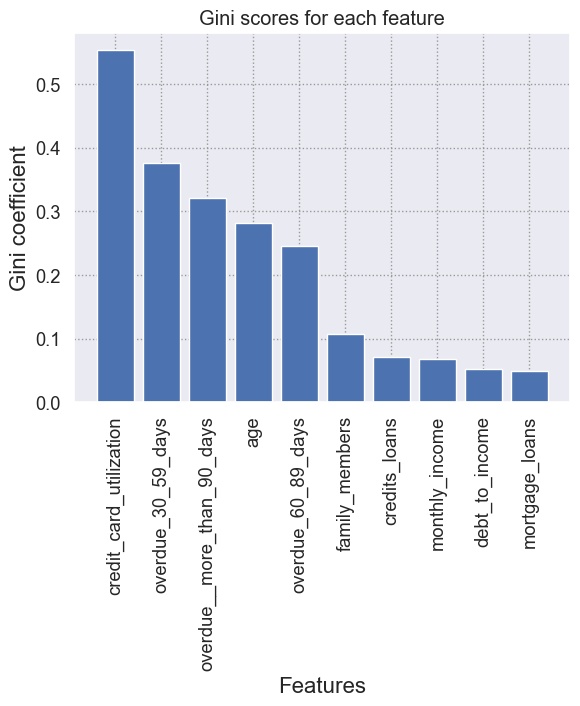

Эффективность ранжирования факторов:
Red signal: mortgage_loans has Gini = 0.0497
****************************************************************************************************
0.025 перцентиль бутстрэп-распределения Джини по факторам:
Red signal:
mortgage_loans имеет 0.025 перцентиль gini = 0.0067
debt_to_income имеет 0.025 перцентиль gini = 0.0106
credits_loans имеет 0.025 перцентиль gini = 0.0252
monthly_income имеет 0.025 перцентиль gini = 0.0279
****************************************************************************************************
Оценка information value:
IV for credit_card_utilization: 1.1898222790285706
IV for age: 0.287804751507897
IV for overdue_30_59_days: 0.7744478028483714
IV for debt_to_income: 0.1271323885883821
IV for monthly_income: 0.13209785611257355
IV for credits_loans: 0.11796904044163478
IV for overdue__more_than_90_days: 0.897557440547973
IV for mortgage_loans: 0.08255746855485639
IV for overdue_60_89_days: 0.6254038006669864
IV for family_me

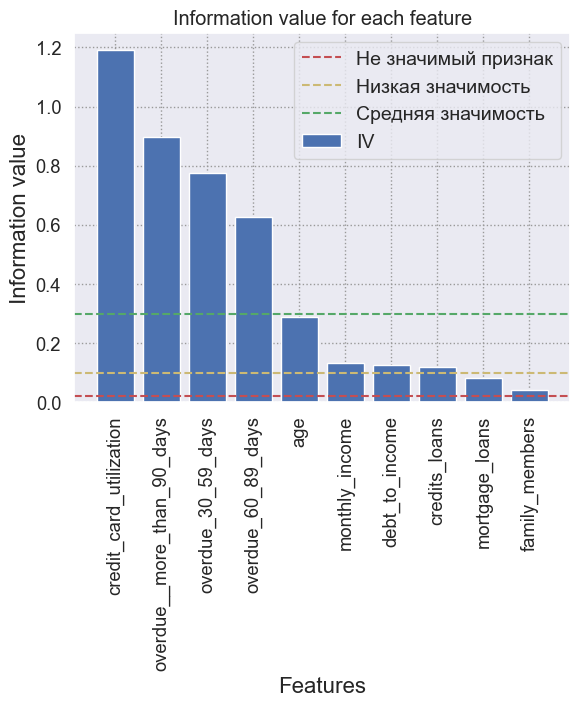

In [28]:
# проведение оценки Джини в разрезе факторов
print(get_ginis_of_features(X_tr=X_tr, y_tr=y_tr, X_te=X_te, y_te=y_te, red_zone=0.05, yellow_zone=0.15))
print('*'*100)

# проверка 2.5 перцентиля бутстрэп-распределения Джини по факторам
get_ginis_of_features_bootstrap(X_train=X_tr, y_train=y_tr, X_test=X_te, y_test=y_te, sample_fraction=0.5, 
                                    n_samples=1000, alpha=0.025, red_zone=0.03, yellow_zone=0.05)
print('*'*100)

# оценка важности признаков на основе Information Value
get_inform_values(X_train=X_tr, y_train=y_tr, no_value=0.02, small_value=0.1, middle_value=0.3)

##### Итог:
Имеется несколько признаков, которые показали низкое значение Джини и Information Value => слабые зоны модели, стоит внимательно следить за этими признаками. 

####  Тест Колмогорова-Смирнова: выборки X_train и X_test из одного распределения или нет.

In [29]:
# Тест Колмогорова-Смирнова
for i, feature in enumerate(X_tr.columns):
    stat, p = ks_2samp(X_tr.iloc[:,i], X_te.iloc[:,i])
    print('Признак:', feature)
    print(f'p-value = {p}, KS = {stat}')
    if p < 0.05:
        print('Разное распределение')
    else:
        print('Одно распределение')
    print('-'*50)   

Признак: credit_card_utilization
p-value = 0.300337790137402, KS = 0.007491176342595551
Одно распределение
--------------------------------------------------
Признак: age
p-value = 0.8883208098418602, KS = 0.004470736660775354
Одно распределение
--------------------------------------------------
Признак: overdue_30_59_days
p-value = 0.9999997125423725, KS = 0.002049298178675052
Одно распределение
--------------------------------------------------
Признак: debt_to_income
p-value = 0.06344031410794404, KS = 0.010118797488216091
Одно распределение
--------------------------------------------------
Признак: monthly_income
p-value = 0.19046604597639805, KS = 0.008349652252340078
Одно распределение
--------------------------------------------------
Признак: credits_loans
p-value = 0.9809235024430044, KS = 0.0035972329392716107
Одно распределение
--------------------------------------------------
Признак: overdue__more_than_90_days
p-value = 1.0, KS = 0.0012491877010641916
Одно распределение


Тест показывает, что в трейне и тесте признаки имеют одинаковые распределения (точнее то, что нет оснований для отвержения нулевой гипотезы, которая состоит в том, что значения признаков взяты из одно распределения). Посмотрим в дополнение на индекс PSI.

#### Анализ PSI по факторам

In [30]:
get_PSI_results()

Анализ PSI по факторам:


feature       PSI                            conclusion
0     credit_card_utilization  0.000918  Green signal: нет значимых изменений
3              debt_to_income  0.000654  Green signal: нет значимых изменений
4              monthly_income  0.000576  Green signal: нет значимых изменений
5               credits_loans  0.000358  Green signal: нет значимых изменений
1                         age  0.000198  Green signal: нет значимых изменений
7              mortgage_loans  0.000101  Green signal: нет значимых изменений
2          overdue_30_59_days  0.000064  Green signal: нет значимых изменений
9              family_members  0.000045  Green signal: нет значимых изменений
6  overdue__more_than_90_days  0.000000  Green signal: нет значимых изменений
8          overdue_60_89_days  0.000000  Green signal: нет значимых изменений

#### Итог:
Тренировочная и тестовая выборки если и отличаются друг от друга, то незначительно.

## 3.3 Тестирование моделей

In [31]:
# функция для проведения всех тестов для модели
def get_pipeline_test_scores(pipeline, X_test=X_te, y_test=y_te, X_train=X_tr, y_train=y_tr, 
                             sample_fraction=0.3, n_samples=1000, n_repeats=20, plot_feat_imp=True):
    '''
    pipeline - обученная на тренировочных данных модель
    X_train, X_test, y_train, y_test - тренировочные и тестовые данные вместе с метками
    sample_fraction - объем подвыборок при бутстрэпе (доля от объема тестовой выборки)
    n_samples - число сэмплов при бутстрэпе
    n_repeats - количество перемешиваний значений принака (при анализе важности признака методом перемешивания значений)
    plot_feat_imp =True/False - строить ли график feature importance для модели
    '''
    # получение предсказаний модели
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    
    # проверка эффективности ранжирования всей модели по значению gini
    print(efficiency_of_model(gini(y_test, y_pred)))
    print('*'*100)
    
    '''бутстрэп-распределение'''
    # сэмплирование
    samples = generate_bootstrap_samples(y_test, y_pred, sample_fraction = sample_fraction, n_samples=n_samples)
    # получение набора коэффициентов Джини в результате бутстрэпа
    ginis = compute_ginis(samples, confidence=95)
    print('*'*100)
    
    # проверка 2.5 перцентиля бутстрэп-распределения Джини по модели
    print(bootstrap_VaR_of_model(ginis, red_zone=0.3, yellow_zone=0.45, percentile=2.5))
    print('*'*100)
    
    # проверка ES бутстрэп-распределения Джини по модели
    print(bootstrap_ES_of_model(ginis, red_zone=0.2, yellow_zone=0.3, alpha=5))
    print('*'*100)
    
    '''Оценка важности признаков'''
    # оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов
    get_score_after_permutation(pipeline, X_test=X_test, y_test=y_test, n_repeats=n_repeats)
    
    if plot_feat_imp is True:
        # график важности признаков при обучении модели
        get_feat_imp(pipeline)
    
    '''ROC-кривые'''
    # ROC - кривая на тренировочных данных
    y_probas_train = pipeline.predict_proba(X_train)
    plot_roc(y_train, y_probas_train, classes_to_plot=1, plot_micro=False, plot_macro=False, title='ROC Curve: Train Data')
    plt.show()
    print('*'*100)
    
    # ROC - кривая на тестовых данных
    y_probas = pipeline.predict_proba(X_te)
    plot_roc(y_test, y_probas, classes_to_plot=1, plot_micro=False, plot_macro=False, title='ROC Curve: Test Data')
    plt.show()
    print('*'*100)
    
    # Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов
    plot_ks(y_te, y_probas)
    
    # распределение вероятностей дефолта для тестовой выборки
    get_plot_of_scores(y_proba=y_pred)
    
    # распределение вероятностей дефолта для тестовой выборки для групп: target = 0 и target = 1
    plot_scores_on_target(y_pred, y_test)
    
    ''' Насколько хорошо откалибрована модель'''
    # График калибровочной кривой
    get_calibration_curve(y_test, y_pred)
    print('*'*100)
    
    # Проведение биномиального теста
    calibration_binom_test(y_test, y_pred, p_crit=0.05)

## LGBM

Эффективность ранжирования модели:
Green signal: Gini = 0.7398
****************************************************************************************************


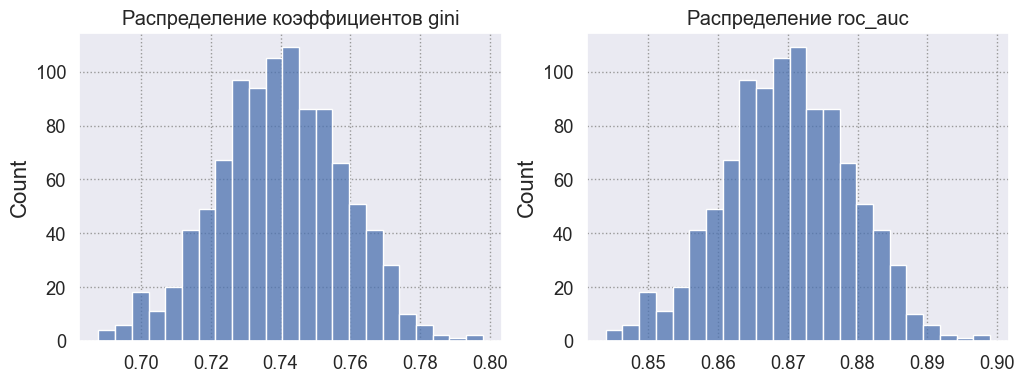

95%-ный доверительный интервал для gini: [0.7019, 0.7728]
95%-ный доверительный интервал для roc_auc: [0.8510, 0.8864]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.7019
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.7018
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
credit_card_utilization        0.1156  +/-  0.0072
overdue__more_than_90_days     0.0641  +/-  0.0036
overdue_30_59_days             0.0571  +/-  0.0047
overdue_60_89_days             0.0447  +/-  0.0023
age                            0.0266  +/-  0.0042
credits_lo

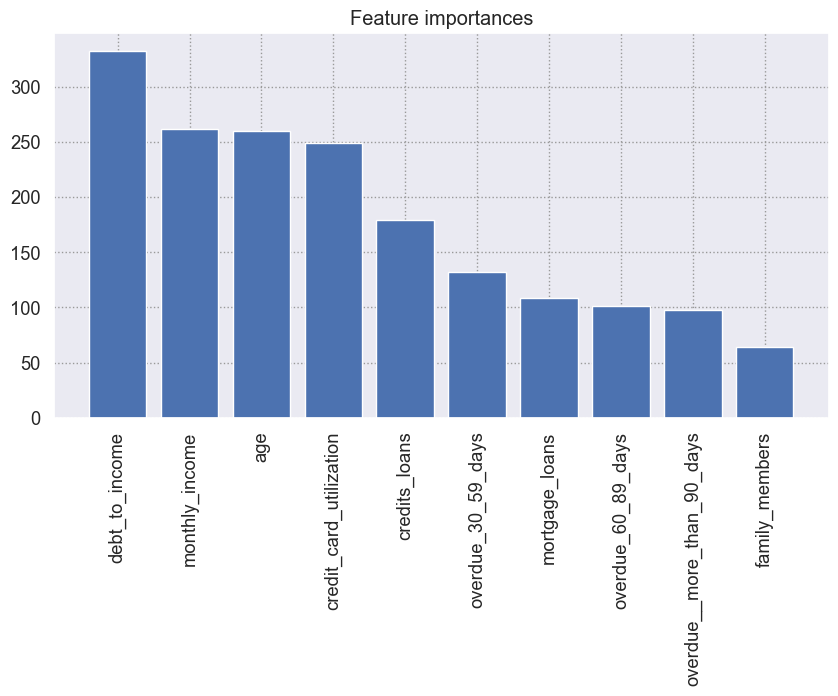

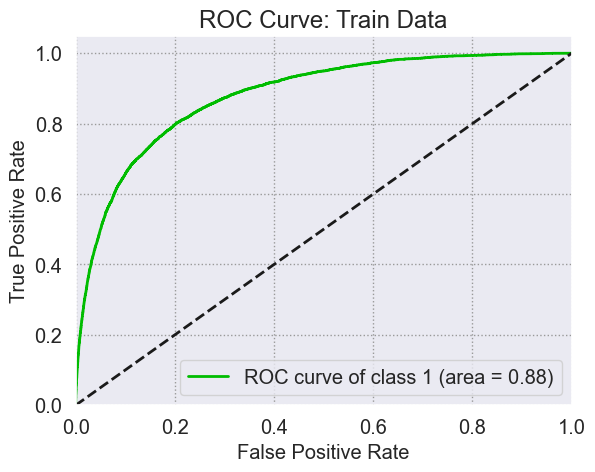

****************************************************************************************************


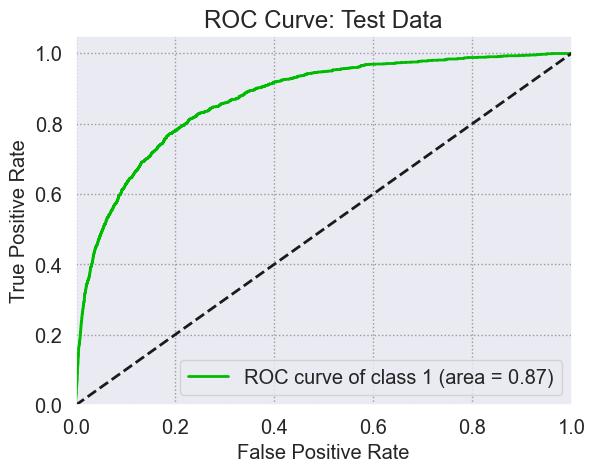

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


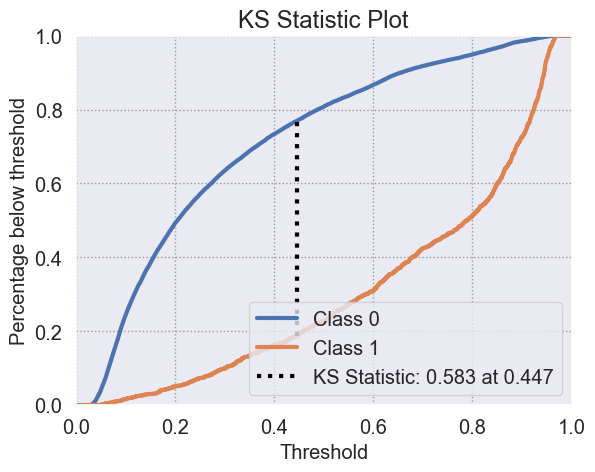

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


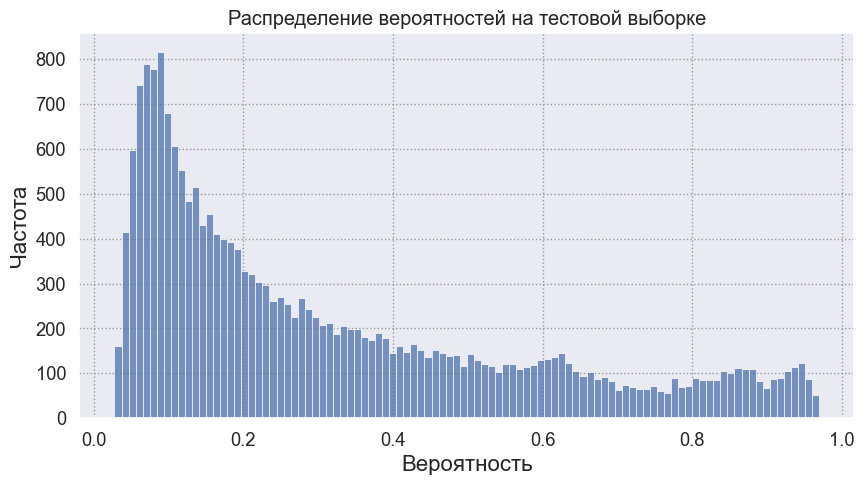

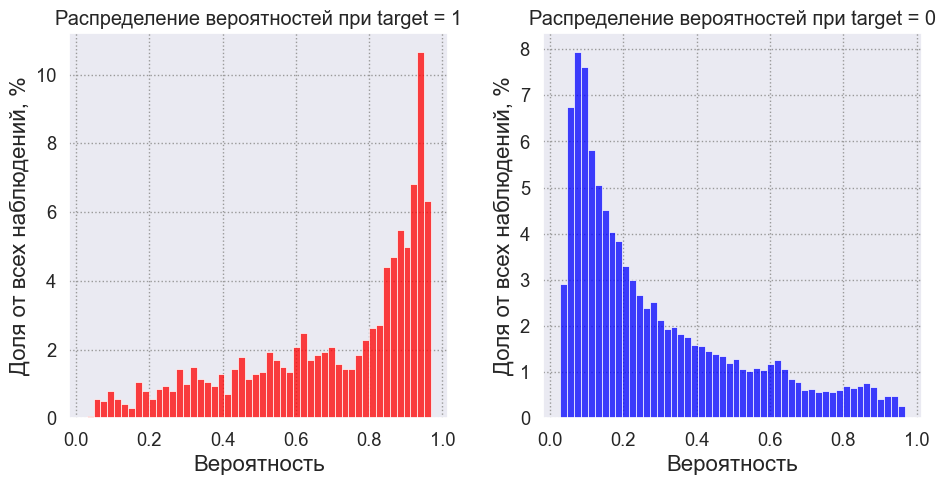

****************************************************************************************************


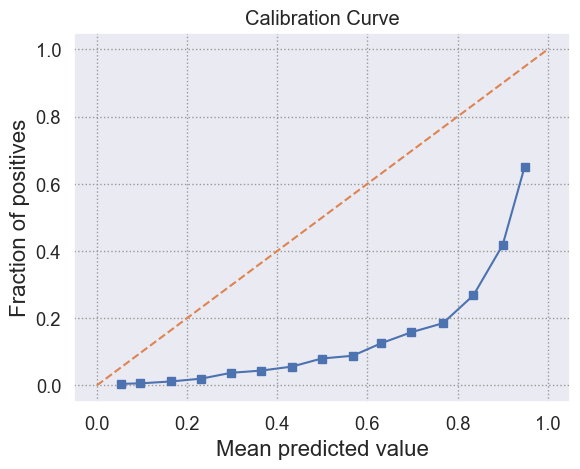

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.0000 => отвергаем H0 => модель плохо откалибрована


In [32]:
# LGBM
get_pipeline_test_scores(LGBM_pipeline, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000)

## CatBoost

Эффективность ранжирования модели:
Green signal: Gini = 0.7412
****************************************************************************************************


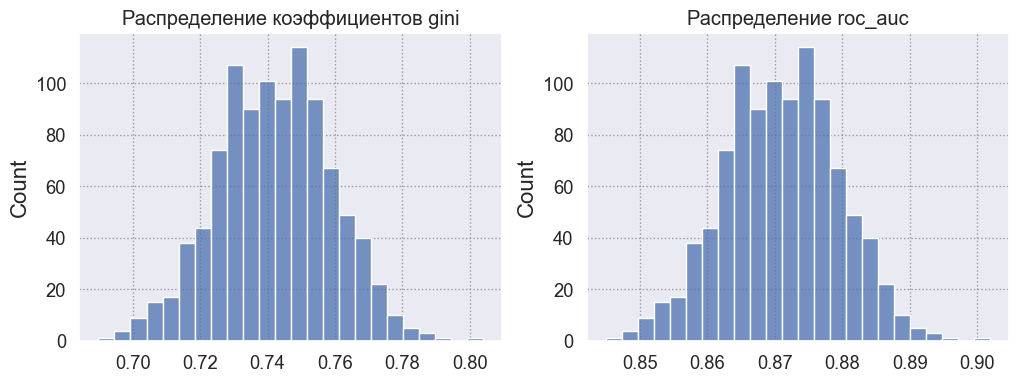

95%-ный доверительный интервал для gini: [0.7084, 0.7743]
95%-ный доверительный интервал для roc_auc: [0.8542, 0.8871]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.7084
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.7072
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
overdue__more_than_90_days     0.1103  +/-  0.0030
credit_card_utilization        0.0596  +/-  0.0037
overdue_60_89_days             0.0532  +/-  0.0020
overdue_30_59_days             0.0485  +/-  0.0026
age                            0.0079  +/-  0.0027
monthly_in

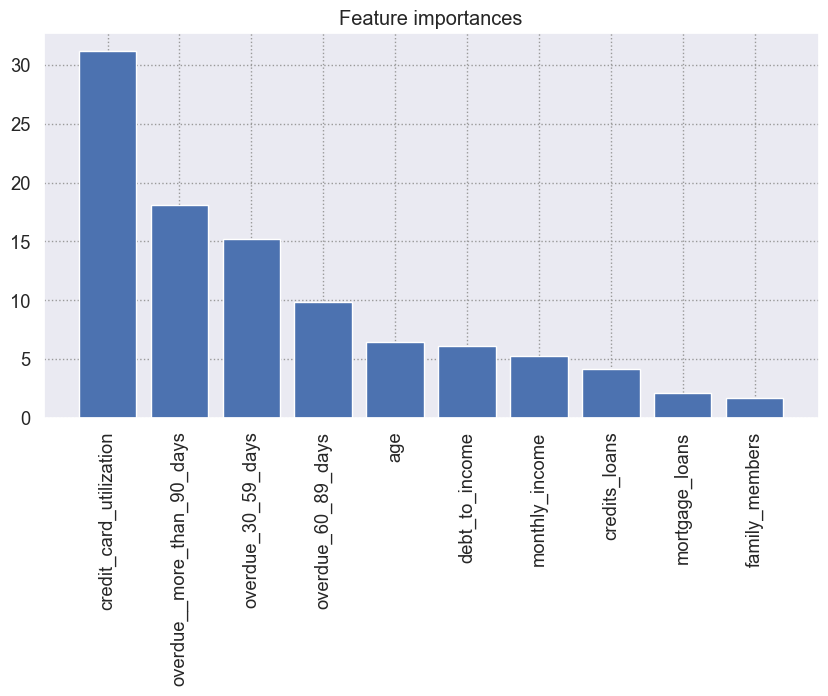

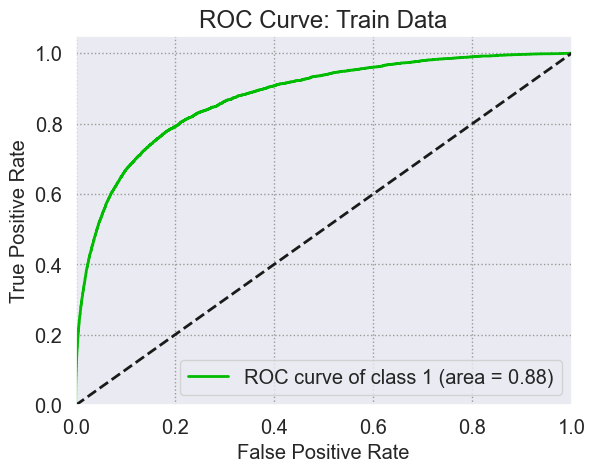

****************************************************************************************************


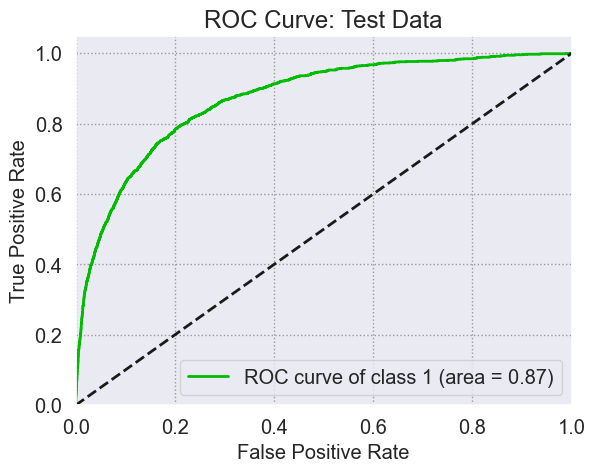

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


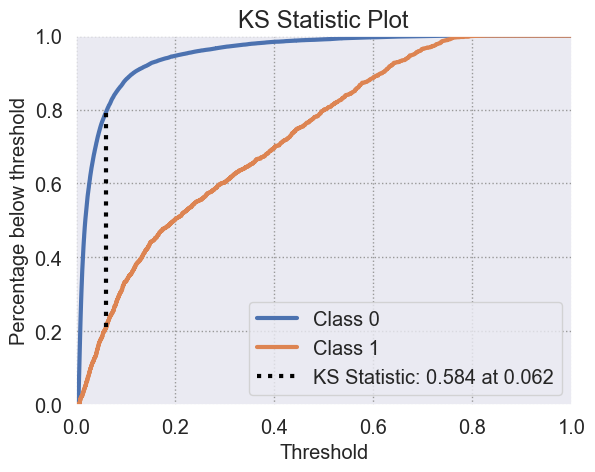

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


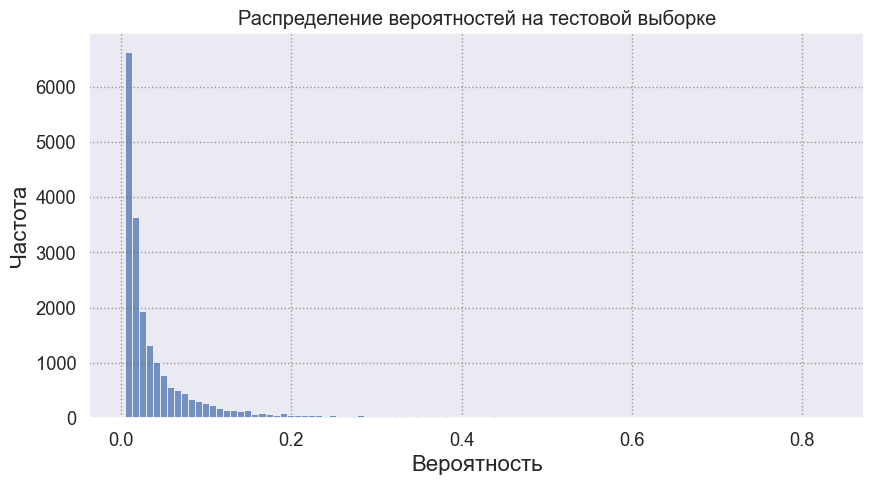

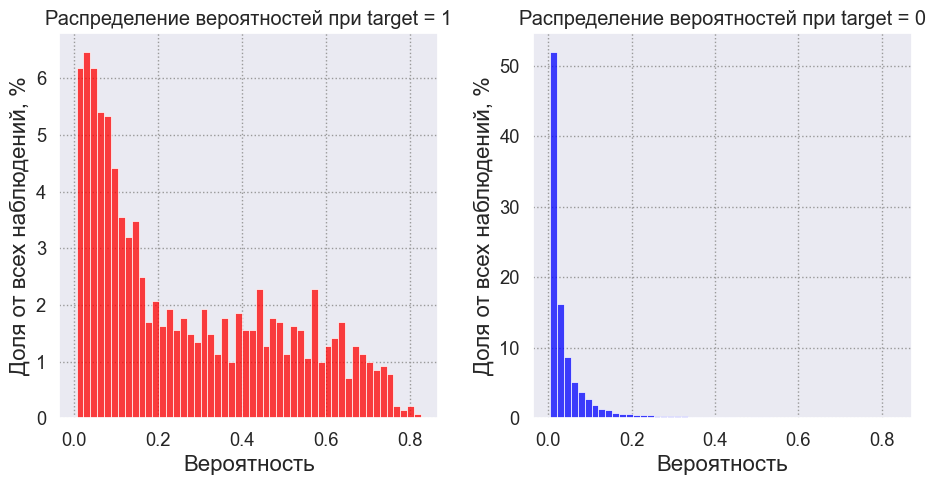

****************************************************************************************************


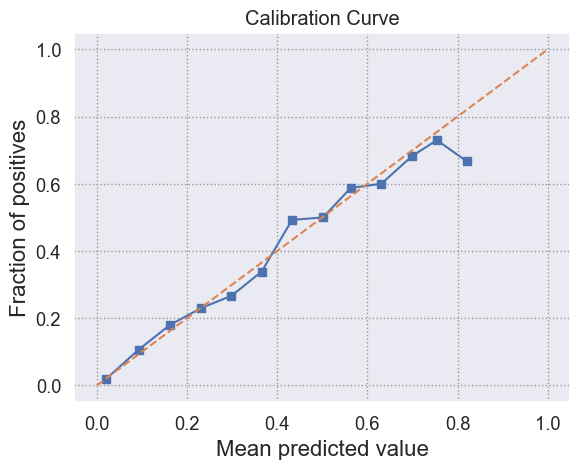

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.5976 => нет оснований отвергать H0 => модель скорее всего хорошо откалибрована


In [33]:
# CatBoost
get_pipeline_test_scores(catboost_pipeline, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000)

## XGBoost

Эффективность ранжирования модели:
Green signal: Gini = 0.7372
****************************************************************************************************


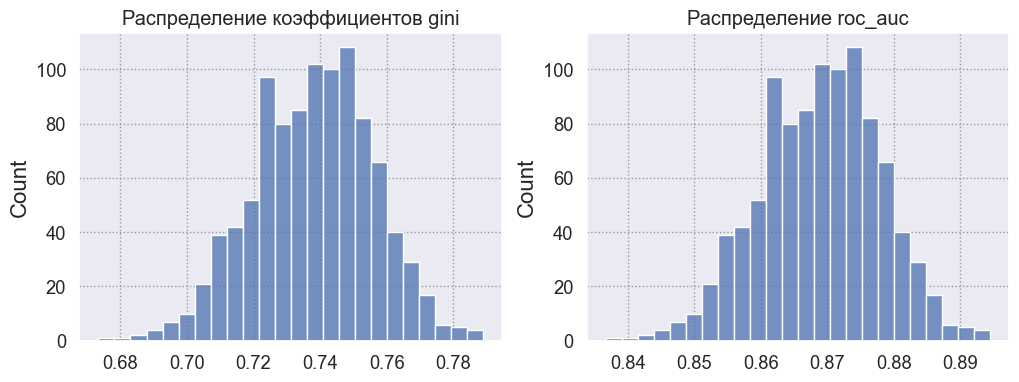

95%-ный доверительный интервал для gini: [0.7027, 0.7710]
95%-ный доверительный интервал для roc_auc: [0.8514, 0.8855]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.7027
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.6999
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
overdue__more_than_90_days     0.1261  +/-  0.0034
credit_card_utilization        0.0874  +/-  0.0042
overdue_60_89_days             0.0640  +/-  0.0021
overdue_30_59_days             0.0548  +/-  0.0024
age                            0.0175  +/-  0.0041
monthly_in

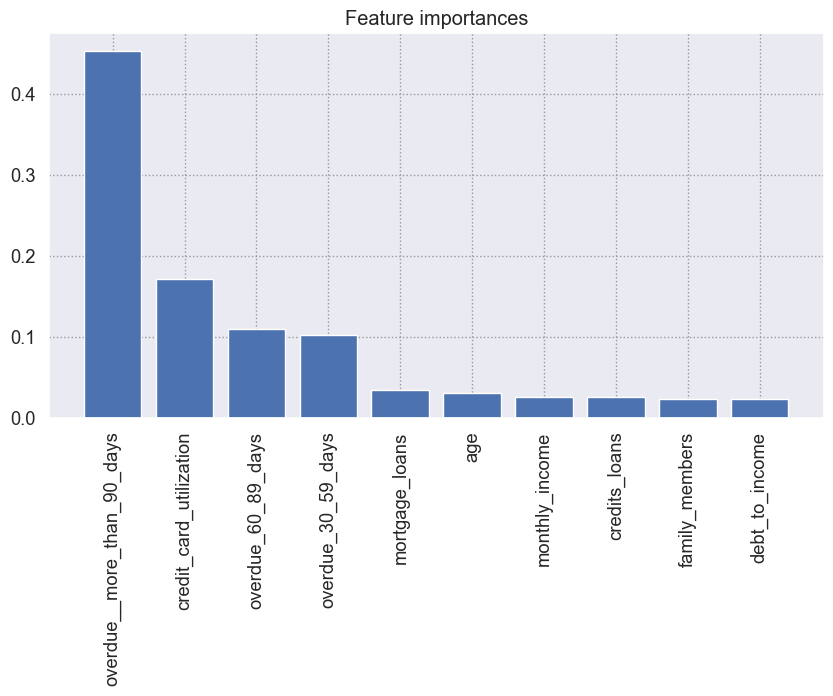

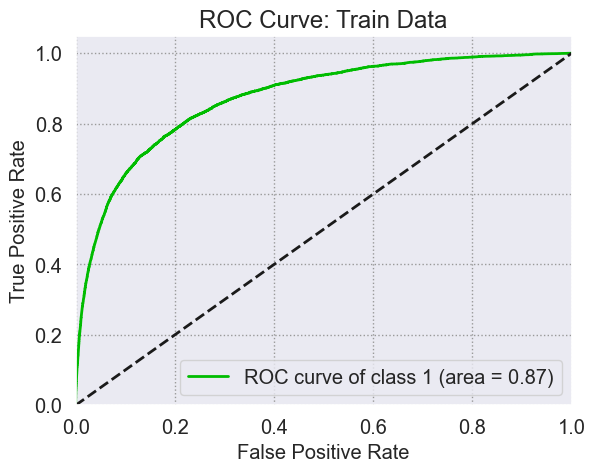

****************************************************************************************************


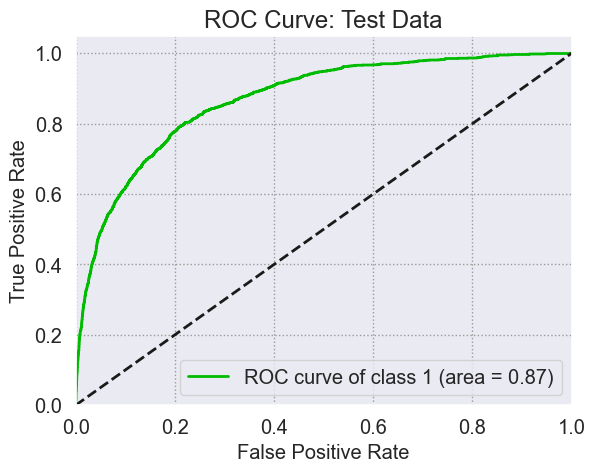

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


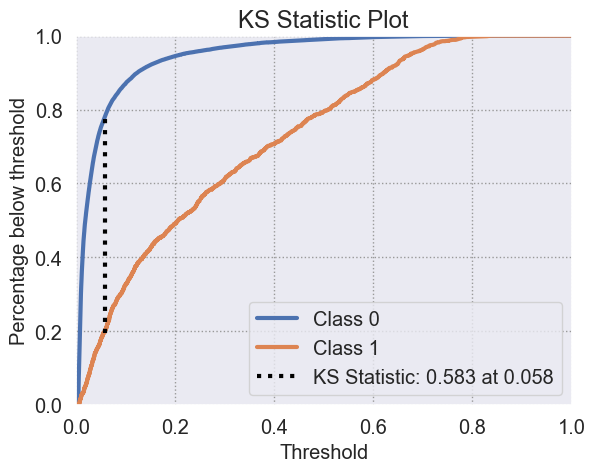

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


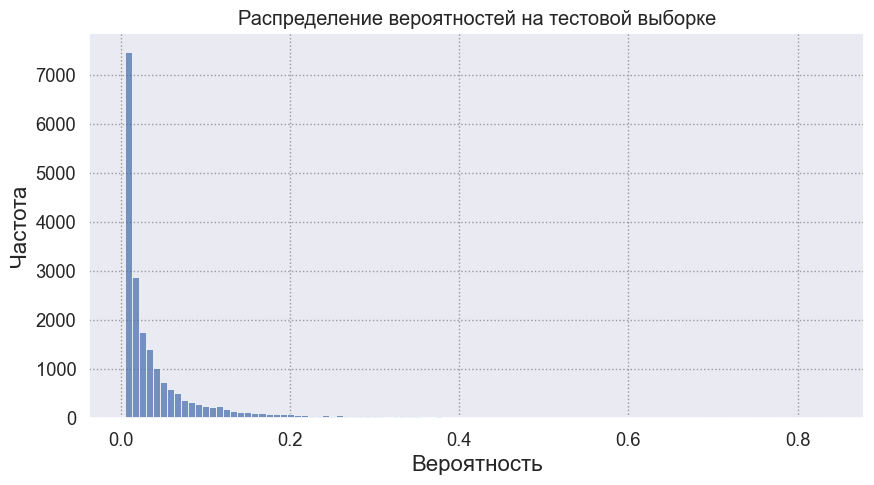

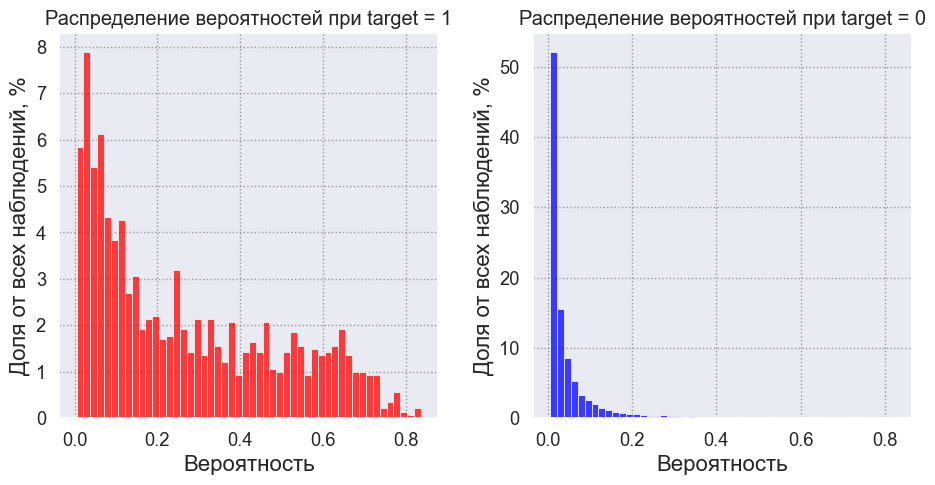

****************************************************************************************************


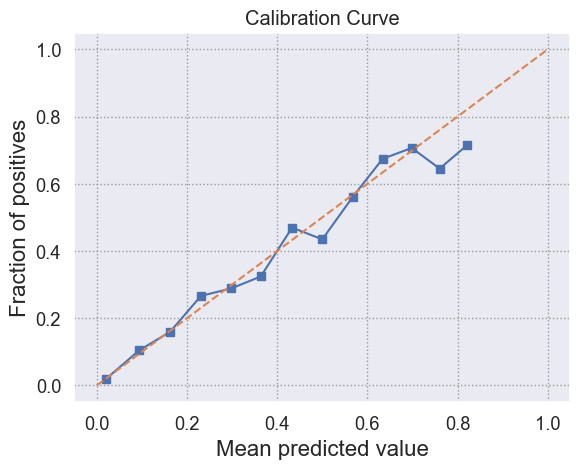

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.8573 => нет оснований отвергать H0 => модель скорее всего хорошо откалибрована


In [34]:
# XGBoost
get_pipeline_test_scores(xg_pipeline, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000)

## GradientBoostingMachine

Эффективность ранжирования модели:
Green signal: Gini = 0.7391
****************************************************************************************************


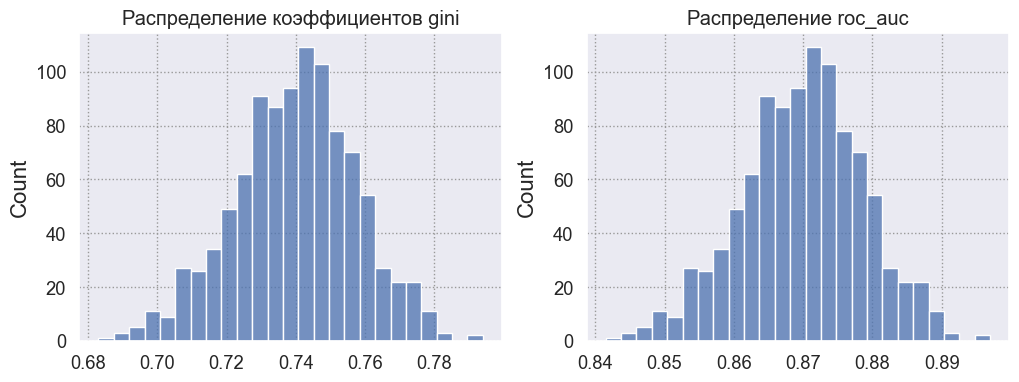

95%-ный доверительный интервал для gini: [0.7036, 0.7744]
95%-ный доверительный интервал для roc_auc: [0.8518, 0.8872]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.7036
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.7015
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
overdue__more_than_90_days     0.1113  +/-  0.0029
credit_card_utilization        0.0649  +/-  0.0030
overdue_60_89_days             0.0588  +/-  0.0022
overdue_30_59_days             0.0481  +/-  0.0030
debt_to_income                 0.0064  +/-  0.0036
age       

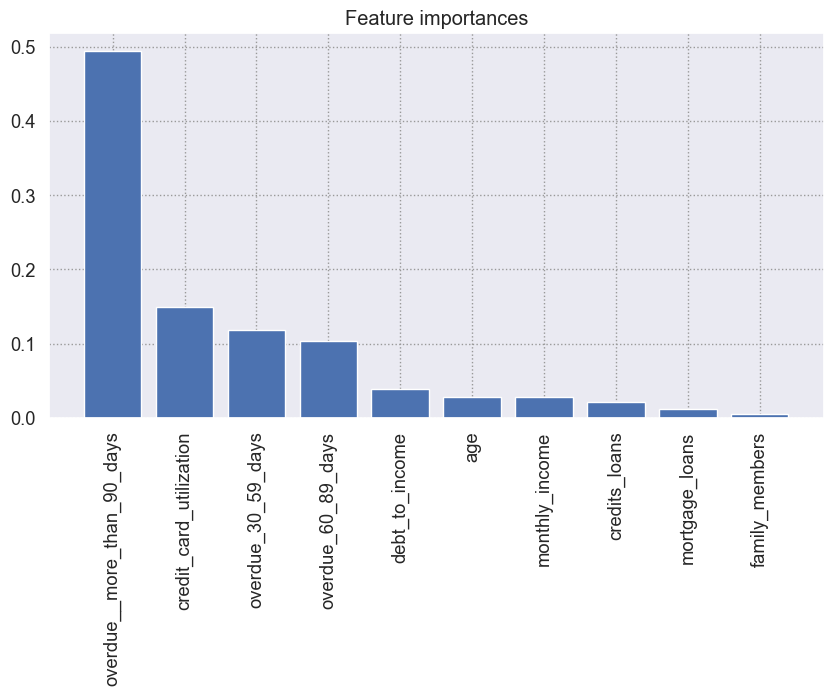

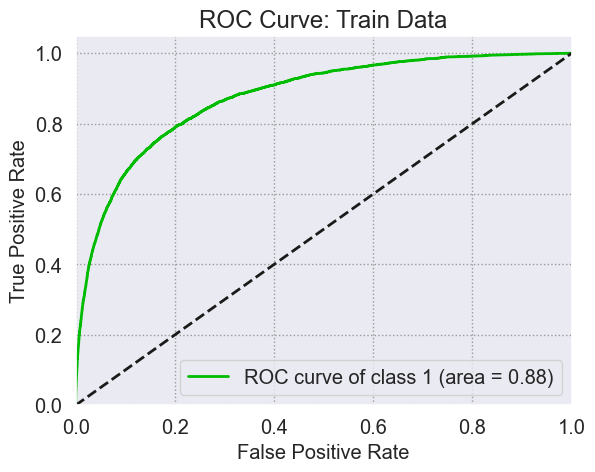

****************************************************************************************************


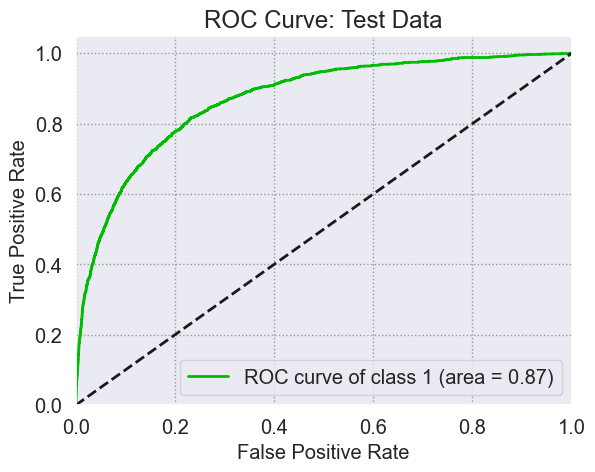

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


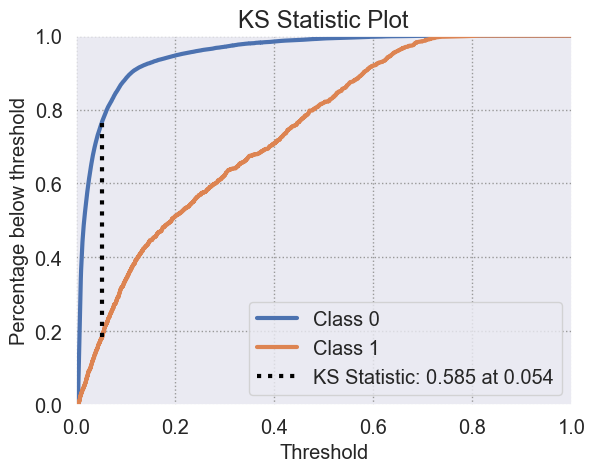

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


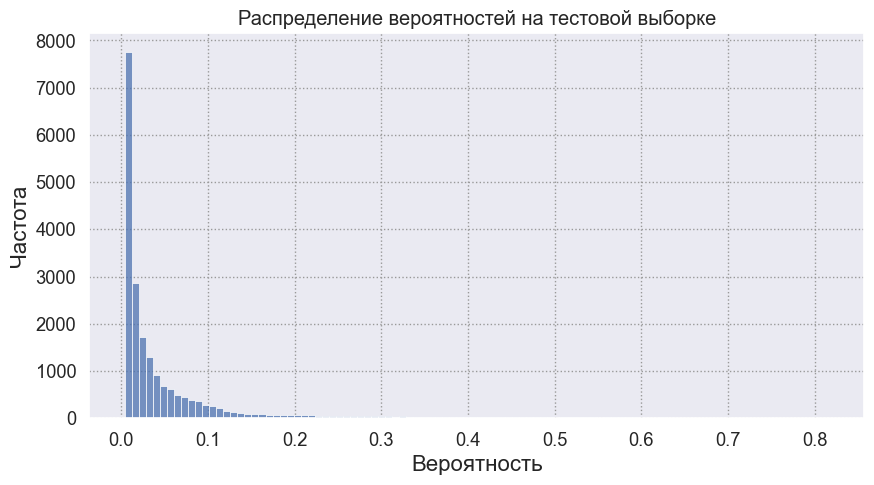

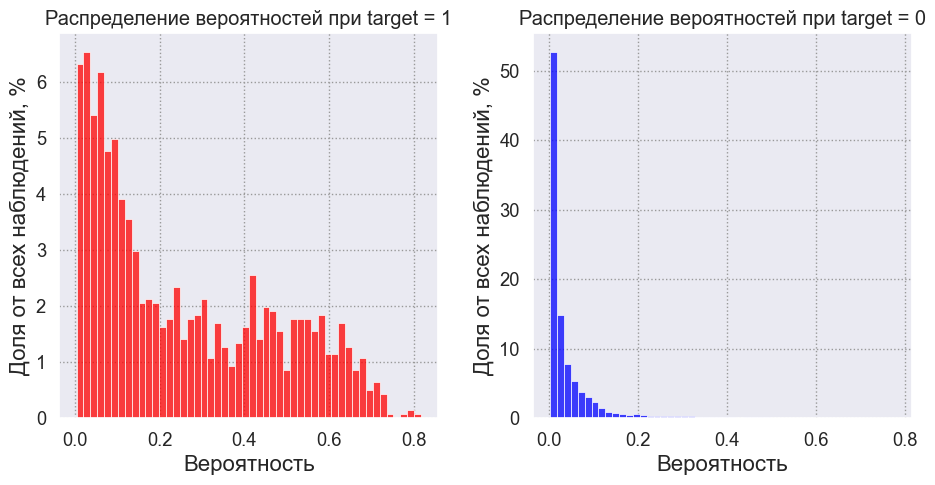

****************************************************************************************************


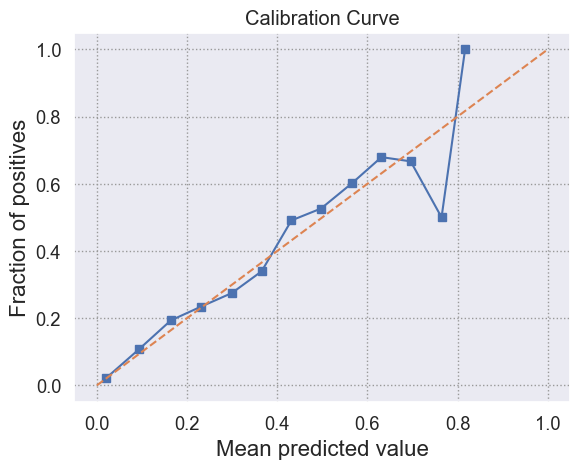

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.0215 => отвергаем H0 => модель плохо откалибрована


In [35]:
# GradientBoostingMachine
get_pipeline_test_scores(gbc_pipeline, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000)

## Нейронная сеть

Эффективность ранжирования модели:
Green signal: Gini = 0.6699
****************************************************************************************************


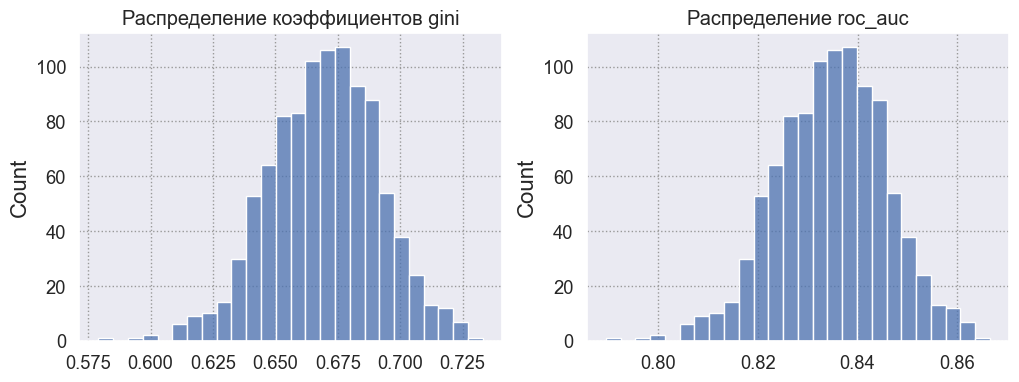

95%-ный доверительный интервал для gini: [0.6242, 0.7124]
95%-ный доверительный интервал для roc_auc: [0.8121, 0.8562]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.6242
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.6215
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
overdue__more_than_90_days     0.1260  +/-  0.0031
overdue_60_89_days             0.0525  +/-  0.0022
overdue_30_59_days             0.0389  +/-  0.0023
family_members                 0.0022  +/-  0.0025
age                            0.0010  +/-  0.0027
credit_car

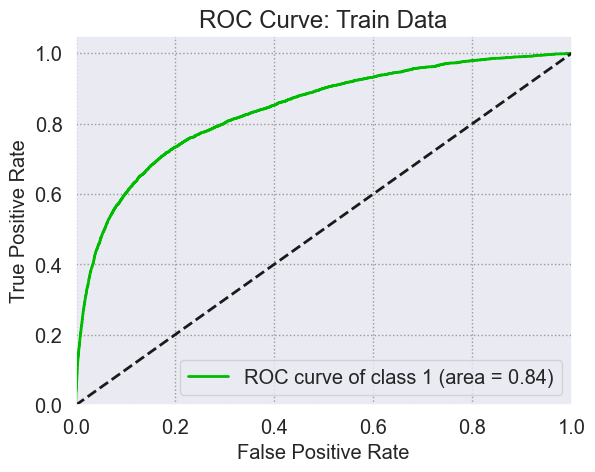

****************************************************************************************************


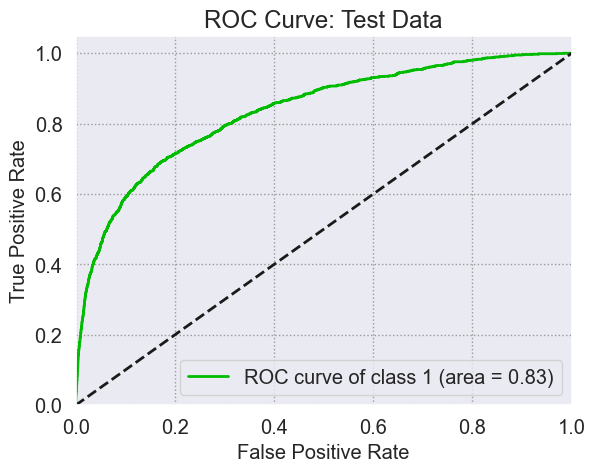

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


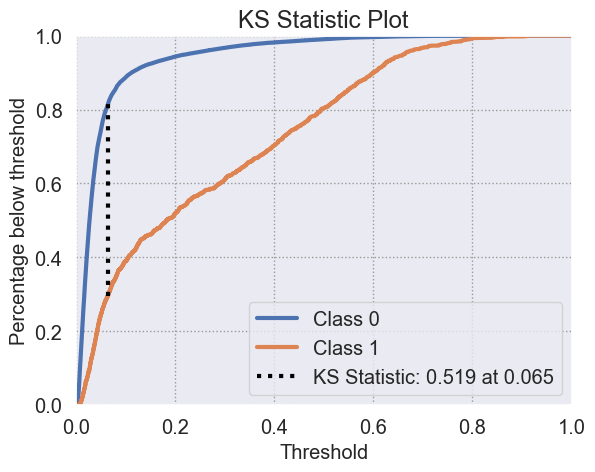

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


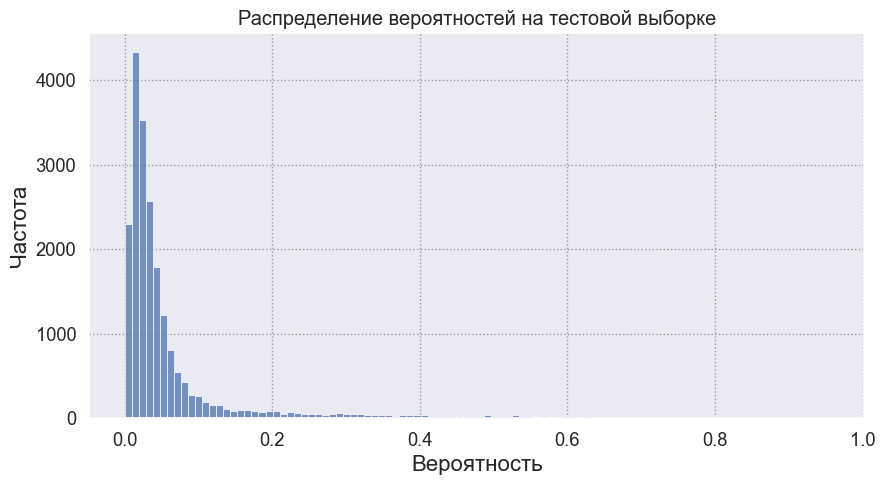

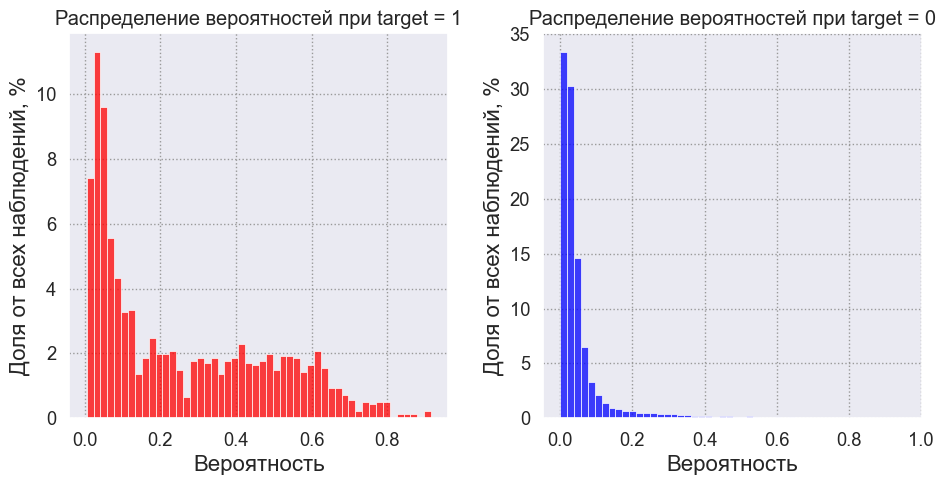

****************************************************************************************************


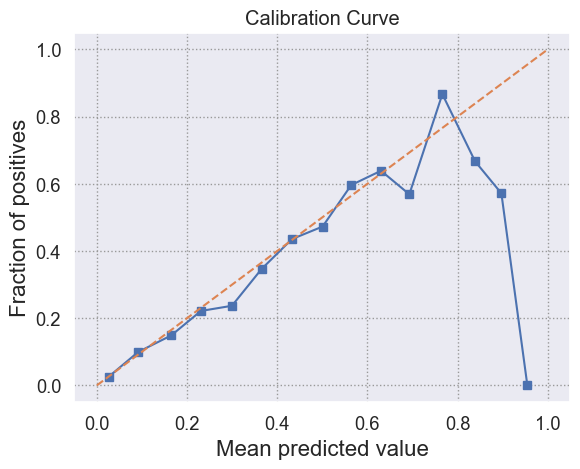

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.2878 => нет оснований отвергать H0 => модель скорее всего хорошо откалибрована


In [36]:
# Нейронная сеть
get_pipeline_test_scores(nn_pipeline, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000, plot_feat_imp=False)

## CatBoost + LGBM

Эффективность ранжирования модели:
Green signal: Gini = 0.7420
****************************************************************************************************


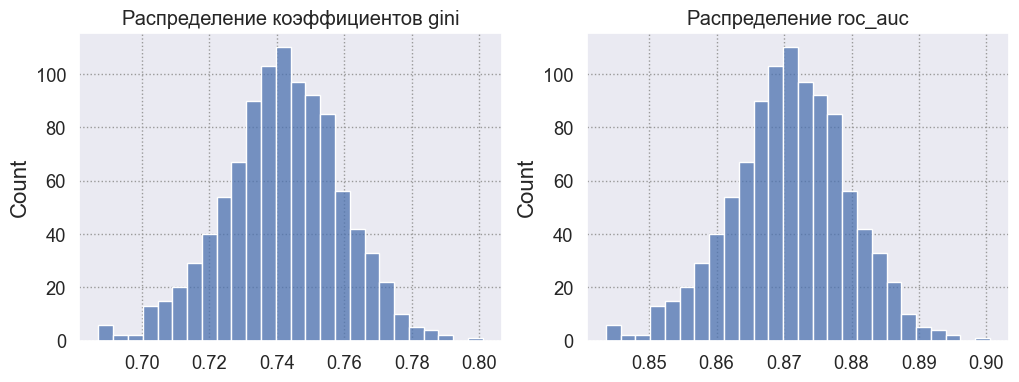

95%-ный доверительный интервал для gini: [0.7049, 0.7740]
95%-ный доверительный интервал для roc_auc: [0.8525, 0.8870]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.7049
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.7035
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
overdue__more_than_90_days     0.1297  +/-  0.0040
credit_card_utilization        0.0710  +/-  0.0035
overdue_60_89_days             0.0617  +/-  0.0023
overdue_30_59_days             0.0589  +/-  0.0021
age                            0.0127  +/-  0.0034
family_mem

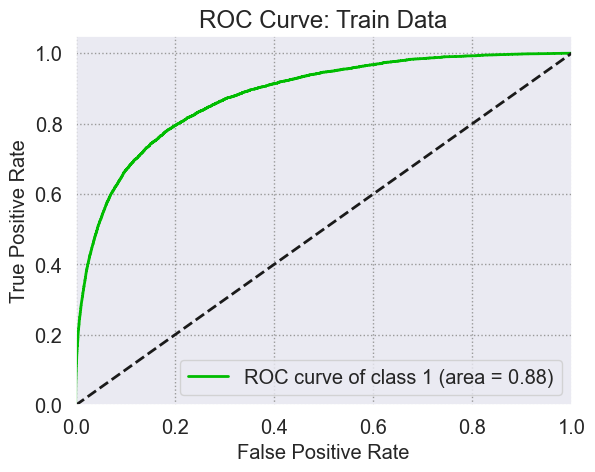

****************************************************************************************************


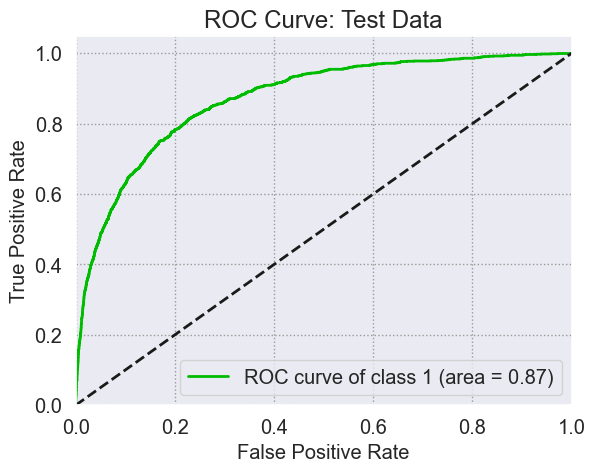

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


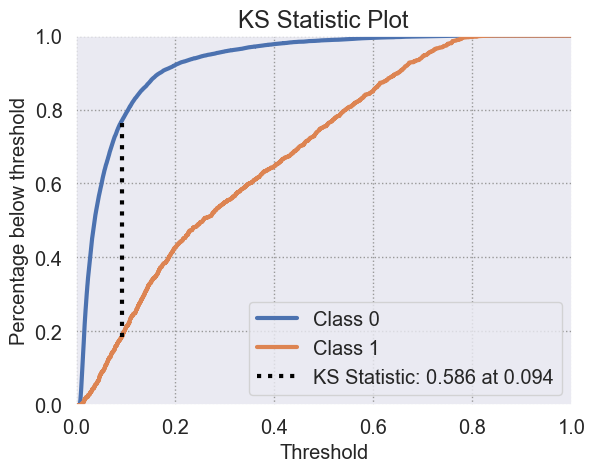

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


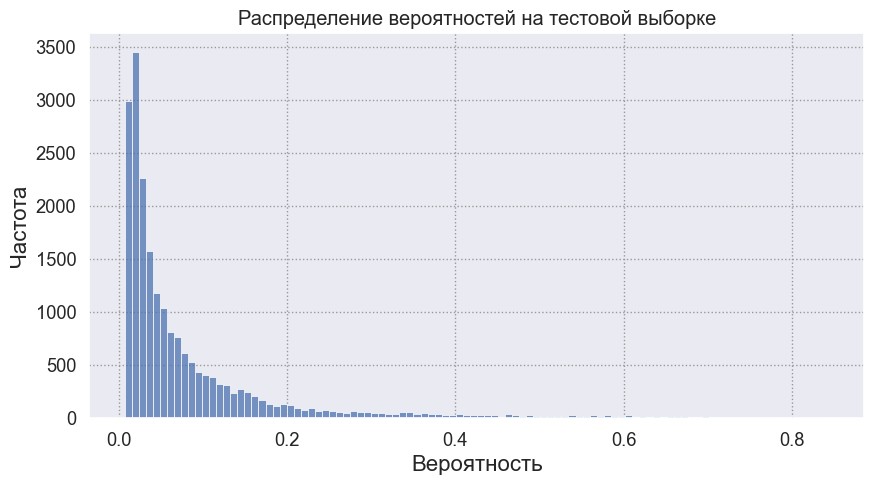

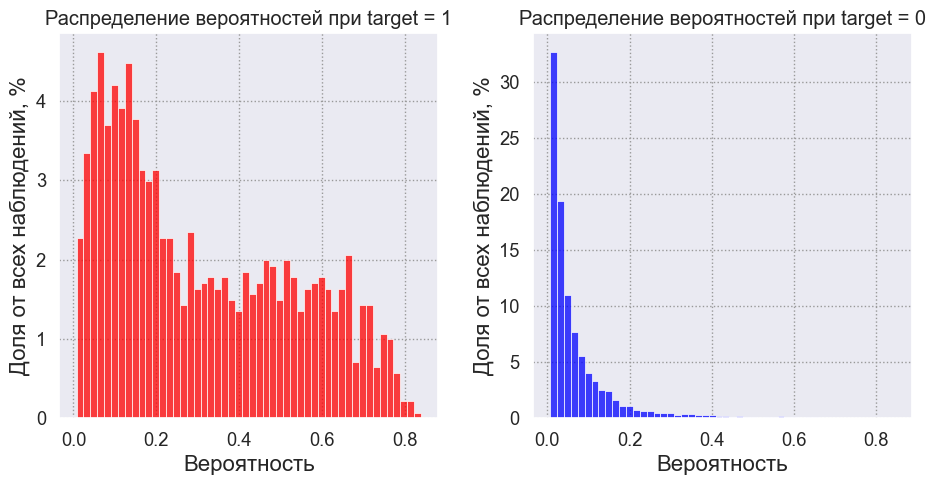

****************************************************************************************************


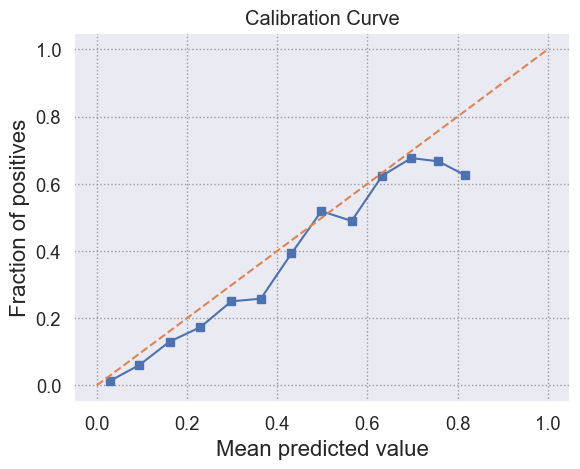

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.0000 => отвергаем H0 => модель плохо откалибрована


In [37]:
# Catboost+LGBM
get_pipeline_test_scores(vc_cb_lgbm, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000, plot_feat_imp=False)

## CatBoost + LGBM + NN

Эффективность ранжирования модели:
Green signal: Gini = 0.7422
****************************************************************************************************


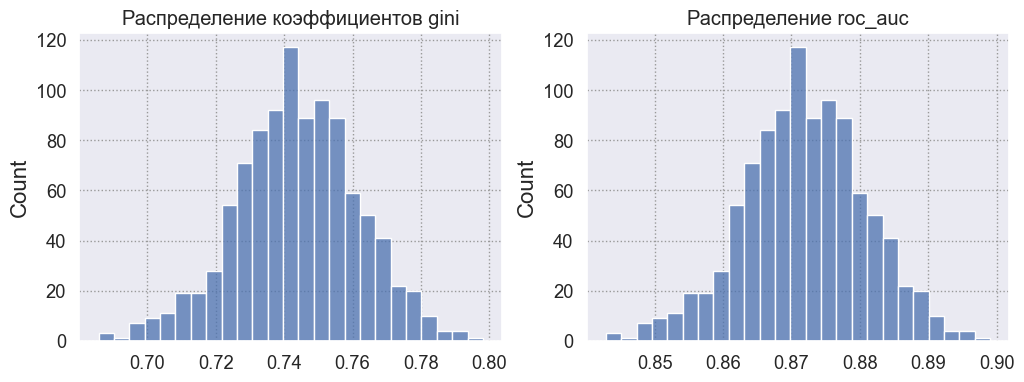

95%-ный доверительный интервал для gini: [0.7062, 0.7779]
95%-ный доверительный интервал для roc_auc: [0.8531, 0.8890]
****************************************************************************************************
2.5 перцентиль бутстрэп-распределения Джини по модели:
Green signal: Gini(2.5%) = 0.7062
****************************************************************************************************
ES(5%) бутстрэп-распределения Джини по модели:
Green signal: ES(5%) = 0.7041
****************************************************************************************************
Оценка важности атрибутов на тестовых данных путем перемешивания значений признака для объектов:
Признак                      mean_delta       std
overdue__more_than_90_days     0.1213  +/-  0.0034
credit_card_utilization        0.0563  +/-  0.0037
overdue_30_59_days             0.0531  +/-  0.0025
overdue_60_89_days             0.0525  +/-  0.0020
age                            0.0092  +/-  0.0026
family_mem

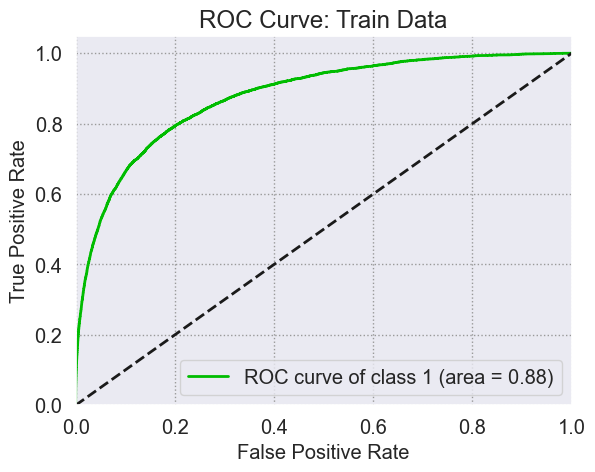

****************************************************************************************************


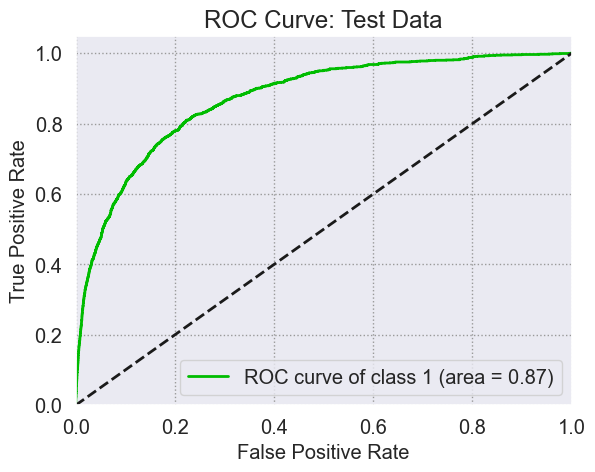

****************************************************************************************************
Тест Колмогорова-Смирнова для сравнения вероятностей предсказаний модели объектов различных классов:


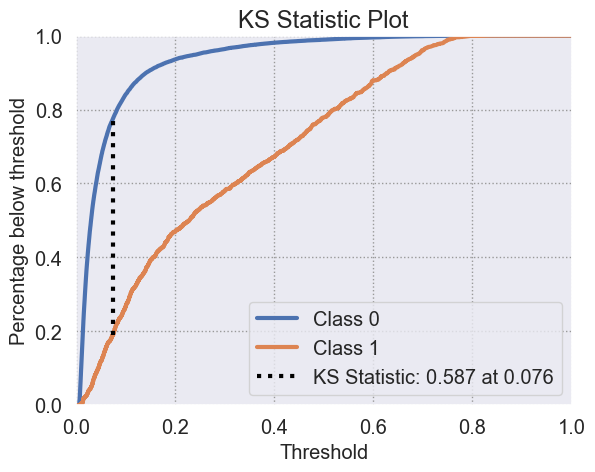

Критическое значение для уровня значимости 0.05: crit_value = 0.0374
****************************************************************************************************


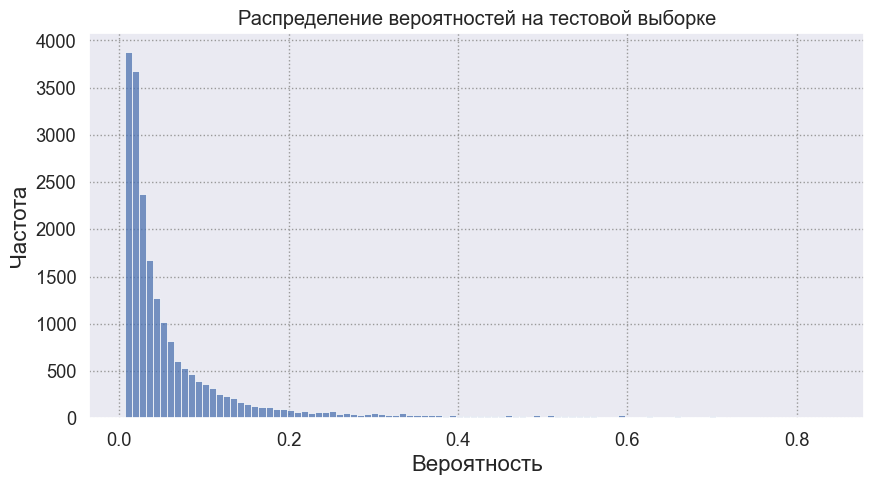

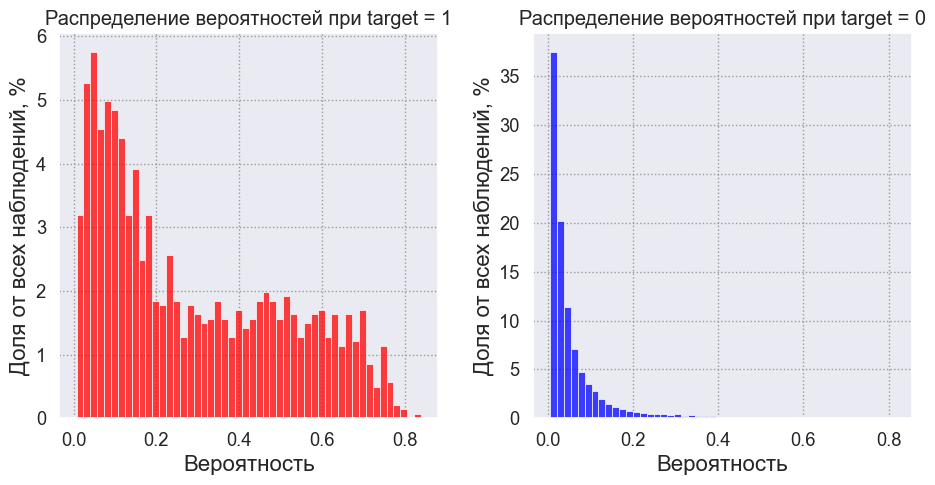

****************************************************************************************************


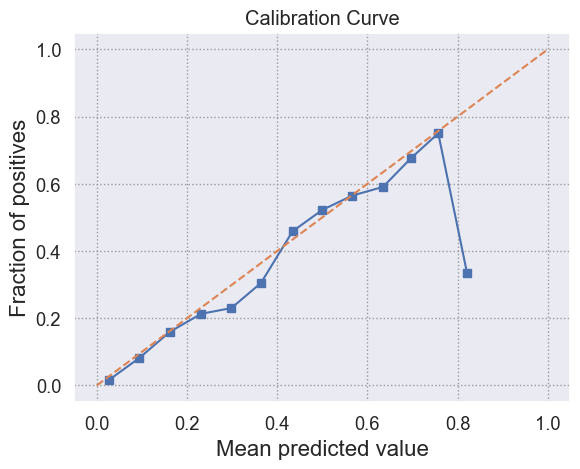

****************************************************************************************************
Результаты биномиального теста: насколько хорошо откалибрована модель?
p_value = 0.0000 => отвергаем H0 => модель плохо откалибрована


In [38]:
# Catboost+LGBM+NN
get_pipeline_test_scores(vc_cb_lgbm_nn, X_test=X_te, y_test=y_te, sample_fraction=0.3, n_samples=1000, plot_feat_imp=False)

### Выводы:
1. LGBM: В меру агрессивная модель, очень много больших по модулю вероятностей дефолта выдает, нет красных или желтых сигналов. Однако требуется провести еще калибровку модели.
2. Нейронная сеть - значительно уступает по качеству остальным моделям
3. Остальные модели - в меру "осторожные" (в другом ноутбуке есть графики различных метрик, где отражено, что precision этих моделей в районе 50-60% в то время как у LGBM 20%), однако у них низкое значение recall.
4. Результаты тестирования моделей представлены выше.

## Отчет интерпретации Shap

In [39]:
# !pip install shap
import shap

На графиках ниже переменные ранжируются в порядке убывания. Цвет точки показывает то, большое или малое значение переменной. Расположение точки в горизонтальном пространстве показывает влияние этого значения на принятие решения соотнесения к классу (если правее вертикальной черты => влияние на соотнесение к классу 1, если левее, то к классу 0). Толщина показывает насколько много точек с таким значением Шэппи.

#### Catboost

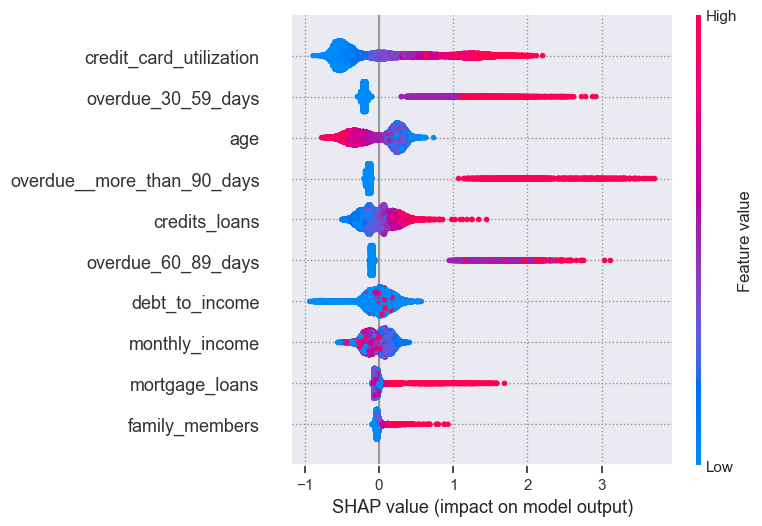

In [40]:
# Получение оценок SHAP для тестовых данных
X_te_transformed = catboost_pipeline.named_steps['transformer'].transform(X_te)
explainer_catboost = shap.Explainer(catboost_pipeline.named_steps["model"], feature_names=X_te.columns)
shap_values_catboost = explainer_catboost(X_te_transformed)

# Генерация отчета интерпретации SHAP
shap.summary_plot(shap_values_catboost, X_te_transformed)

Тут очень много можно почерпнуть информации. Например:
- С увеличением членов семьи увеличивается вероятность дефолта
- С увеличением текущего количества ипотечных займов, займов и кредитных линий, числа предыдущих просрочек по кредитам увеличивается вероятность дефолта
- С увеличением возраста клиента в целом уменьшается вероятность дефолта и т.д.

По аналогии можно написать выводы и для других моделей.

#### LGBM

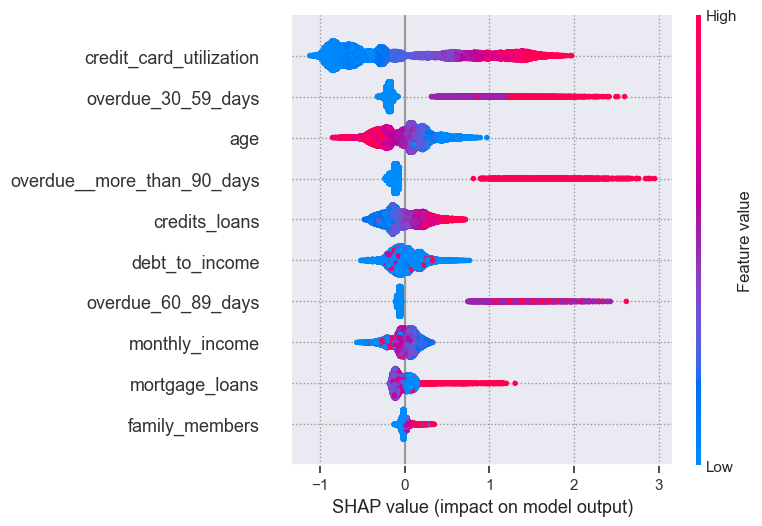

In [41]:
# Получение оценок SHAP для тестовых данных
X_te_transformed = LGBM_pipeline.named_steps['transformer'].transform(X_te)
explainer_LGBM = shap.Explainer(LGBM_pipeline.named_steps['model'], feature_names=X_te.columns)
shap_values_LGBM = explainer_LGBM(X_te_transformed)

# Генерация отчета интерпретации SHAP
shap.summary_plot(shap_values_LGBM[:,:,1], X_te)

#### GradientBoostingMachine

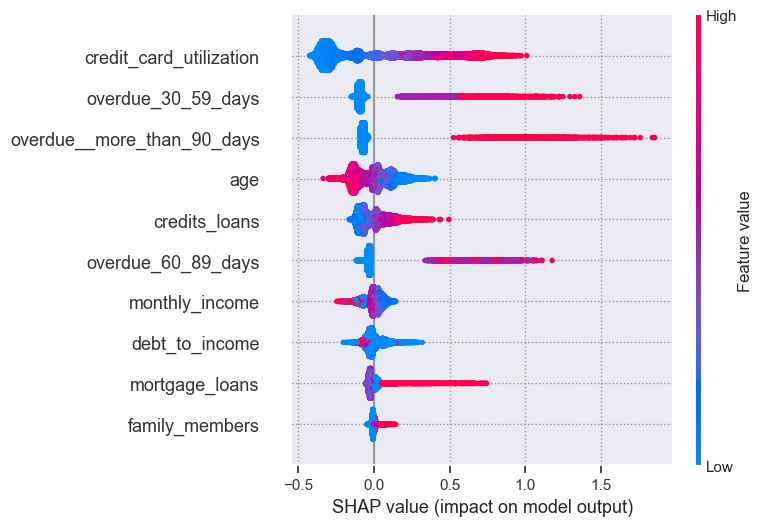

In [42]:
# Получение оценок SHAP для тестовых данных
X_te_transformed = gbc_pipeline.named_steps['transformer'].transform(X_te)
explainer_gbc = shap.Explainer(gbc_pipeline.named_steps["model"], feature_names=X_te.columns)
shap_values_gbc = explainer_gbc(X_te_transformed)

# Генерация отчета интерпретации SHAP
shap.summary_plot(shap_values_gbc, X_te_transformed)

# 4. Вывод:
Анализируя графики можно прийти к выводу о том, что, в целом, модели не противоречат здравому смыслу: чем больше членов семьи,  
текущее количество ипотечных займов, займов и кредитных линий, число предыдущих просрочек по кредитам, отношение баланса на счету к лимиту по кредиту, тем больше вероятность дефолта. С другой стороны, чем больше месячный доход клиента, тем менее вероятно, чем произойдет просрочка.

CatBoost-модель имеет более высокий precision, что означает, что она более консервативна в определении дефолтных клиентов. То есть, она склонна относить к классу 1 только тех клиентов, которые она считает наиболее вероятными дефолтниками. Однако, у нее низкий recall, что означает, что она пропускает много дефолтных клиентов, которые на самом деле являются дефолтниками, но были отнесены к классу 0.

LGBM-модель имеет более высокий recall, что означает, что она более точно определяет дефолтных клиентов, не пропуская много дефолтных клиентов, которые и на самом деле являются дефолтниками. Однако, у нее низкий precision, что означает, что она может отнести к классу 1 клиентов, которые не являются дефолтниками. Если же сравнивать модели друг с другом, то CatBoost имеет более низкую f-меру, что означает, что она в целом менее эффективна в классификации дефолтных клиентов, чем LGBM.

Однако нужно в первую очередь понять, что для нас важнее: выдать больше кредитов, при этом "отсеивать" наиболее вероятных дефолтников или же тщательно разбирать заявки и работать с теми клиентами, у кого наиболее чистая кредитная история. Если же хотим добиться "золотой середины", то тогда рекомендуется использовать блендинг CatBoost + LGBM.
